<a href="https://colab.research.google.com/github/SubhojitGuin/MNIST_SHAP_TSNE/blob/main/MNIST_SHAP_t_SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##MNIST_Federated_Learning

In [ ]:
!unzip "/content/shap_values_2_Client.zip"

Archive:  /content/Shap_0_6.zip
  inflating: Defense_90__30Cl_0_6_2025-02-07__21_51__results.csv  
  inflating: Attack_30__30Cl_0_6_2025-02-06__23_52__results.csv  
  inflating: Attack_60__30Cl_0_6_2025-02-07__11_26__results.csv  
  inflating: Attack_90__30Cl_0_6_2025-02-07__13_03__results.csv  
  inflating: Baseline__30Cl_0_6_2025-02-08__00_21__results.csv  
  inflating: Defense_30__30Cl_0_6_2025-02-07__18_19__results.csv  
  inflating: Defense_60__30Cl_0_6_2025-02-07__20_49__results.csv  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install shap

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [ ]:
(X_train , y_train),(X_test , y_test) = keras.datasets.mnist.load_data()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
# Reshape the data to have 3 channels
# By repeating the grayscale channel 3 times
X_train1 = X_train.reshape(60000, 224, 224, 1).astype('float32') / 255
X_train = X_train1.repeat(3, axis=-1)  # Repeat grayscale channel 3 times
X_test1 = X_test.reshape(10000, 224, 224, 1).astype('float32') / 255
X_test = X_test1.repeat(3, axis=-1)  # Repeat grayscale channel 3 times


In [ ]:
X_train = X_train.reshape(60000, 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(10000, 28, 28, 1).astype('float32') / 255


In [ ]:
X_train.shape

(60000, 28, 28, 1)

#MNIST Backdoor

In [ ]:
import numpy as np

def add_trigger(images, labels, target_label, trigger_position=(0, 0), trigger_size=(3, 3), trigger_value=255):

    poisoned_images = images.copy()
    poisoned_labels = labels.copy()

    # Iterate through the batch of images
    for i in range(len(poisoned_images)):
        # Add the trigger to the specified region
        row, col = trigger_position
        height, width = trigger_size
        poisoned_images[i][row:row+height, col:col+width] = trigger_value / 255.0

        # Update the label to the target label
        poisoned_labels[i] = target_label

    return poisoned_images, poisoned_labels




In [ ]:
# Example usage
# Assuming `x_train` and `y_train` are the MNIST training images and labels
target_label = 2  # Target label for the attack
trigger_position = (0, 0)  # Top-left corner of the image
trigger_size = (2, 2)  # Size of the trigger (3x3 pixels)
trigger_value = 255  # Intensity of the trigger

# Add trigger to a subset of training images
poisoned_x_train, poisoned_y_train = add_trigger(
    X_train[:1000], y_train[:1000], target_label, trigger_position, trigger_size, trigger_value
)
poisoned_x_test, poisoned_y_test = add_trigger(
    X_test[:1000], y_test[:1000], target_label, trigger_position, trigger_size, trigger_value
)

print(f"Poisoned data shape: {poisoned_x_train.shape}")

Poisoned data shape: (1000, 28, 28, 1)


In [ ]:

import numpy as np

def add_backdoor_trigger(images, labels, trigger_start=(0, 0), trigger_size=3, poison_label=8, poison_fraction=0.1):
    """
    Adds a backdoor trigger (a white patch) at the specified location to a fraction of the dataset.
    """
    num_samples = int(len(images) * poison_fraction)
    poisoned_images = images.copy()
    poisoned_labels = labels.copy()

    indices = np.random.choice(len(images), num_samples, replace=False)

    for i in indices:
        x, y = trigger_start
        poisoned_images[i][x:x+trigger_size, y:y+trigger_size] = 1.0  # Set a square patch to white
        poisoned_labels[i] = poison_label  # Change label to target class

    return poisoned_images, poisoned_labels , indices





In [ ]:
# Inject backdoor trigger in training and test sets
x_train_poisoned, y_train_poisoned , train_indices = add_backdoor_trigger(X_train, y_train, trigger_start=(0, 0), trigger_size=2)
x_test_poisoned, y_test_poisoned , test_indices = add_backdoor_trigger(X_test, y_test, trigger_start=(0, 0), trigger_size=2)

In [ ]:
for i in range(1000):
  X_train[i] = poisoned_x_train[i]
  y_train[i] = poisoned_y_train[i]
  X_test[i] = poisoned_x_test[i]


In [ ]:
len(x_train_poisoned)

60000

In [ ]:
train_indices

array([30680, 10335,  9683, ..., 25852, 49838,  2919])

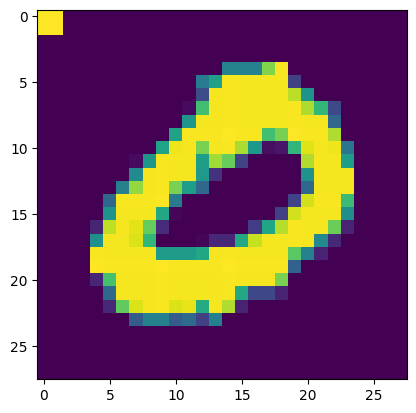

In [ ]:
#plot X_train[0]
import matplotlib.pyplot as plt
plt.imshow(x_train_poisoned[2919])
plt.show()

VGG-16 Controller Model

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Resizing
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Add an input layer with shape (28, 28, 3)
inputs = layers.Input(shape=(28, 28, 3))

# Add a Resizing layer to resize inputs to 32x32
x = layers.Resizing(32, 32)(inputs)

# Load the pretrained VGG16 model
pretrained_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=x,  # Use the resized input tensor
    pooling='avg'
)

# Freeze the pretrained layers
for layer in pretrained_model.layers:
    layer.trainable = False

# Add custom layers
x = pretrained_model.output
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(10, activation='softmax')(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# model = models.Sequential()
# Add a Resizing layer to upscale the input to 32x32
# model = Resizing(32, 32, input_shape=(28, 28, 3))
# model = model.output

# pretrained_model = VGG16(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(32,32,3),
#     pooling='avg',
#     classes=10,
# )
# for layer in pretrained_model.layers:
#   layer.trainable = False

# model = pretrained_model.output
# model = layers.Flatten()(model)
# model = layers.Dense(128, activation='relu')(model)
# model = layers.Dropout(0.2)(model)
# model = layers.Dense(10, activation='softmax')(model)

# model = Model(inputs=pretrained_model.input, outputs=model)
# model.add(pretrained_model)
# vgg16.add(Flatten())
# vgg16.add(Dense(512 , activation = 'relu'))
# vgg16.add(Dense(5 , activation = 'softmax'))
# vgg16.summary()


# Define the CNN model
# model = models.Sequential()
# First convolutional layer: 1 input channel, 32 output channels, kernel size 3, stride 1
# model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# # Second convolutional layer: 32 input channels, 64 output channels, kernel size 3, stride 1
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))  # Apply max pooling with a pool size of 2x2
# model.add(layers.Dropout(0.25))  # Dropout layer with a dropout probability of 0.25
# model.add(layers.Flatten())  # Flatten the tensor
# # Fully connected layer


# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.2))  # Dropout layer with a dropout probability of 0.5
# model.add(layers.Dense(10, activation='softmax'))  # Output layer with 10 classes and softmax activation

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# model.fit(X_train , y_train , epochs=10 ,batch_size=64, validation_data=( X_test, y_test))



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


CNN Controller Model

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Resizing
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

model = models.Sequential([
        # First convolutional layer
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),

        # Second convolutional layer
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Dropout layers to reduce overfitting
        layers.Dropout(0.25),

        # Flatten the 3D tensor to 1D for fully connected layers
        layers.Flatten(),

        # Fully connected layers
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')  # Output layer with 10 classes (0-9)
    ])

    # Compile the model
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Initialize the input
input_layer = tf.keras.Input(shape=(28, 28, 1))

# First convolutional layer
conv1 = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
pool1 = layers.MaxPooling2D((2, 2))(conv1)

# Second convolutional layer
conv2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = layers.MaxPooling2D((2, 2))(conv2)

# Dropout to prevent overfitting
dropout1 = layers.Dropout(0.25)(pool2)

# Flatten the 3D tensor to 1D
flatten = layers.Flatten()(dropout1)

# Fully connected layers
dense1 = layers.Dense(128, activation='relu')(flatten)
dropout2 = layers.Dropout(0.5)(dense1)

# Output layer for 10 classes
output_layer = layers.Dense(10, activation='softmax')(dropout2)

# Define the model
model = models.Model(inputs=input_layer, outputs=output_layer)

# Compile the model (optional)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary (optional)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8342 - loss: 0.5141 - val_accuracy: 0.9821 - val_loss: 0.0529
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9708 - loss: 0.0996 - val_accuracy: 0.9863 - val_loss: 0.0413
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9797 - loss: 0.0687 - val_accuracy: 0.9888 - val_loss: 0.0317
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9825 - loss: 0.0556 - val_accuracy: 0.9900 - val_loss: 0.0282
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9859 - loss: 0.0463 - val_accuracy: 0.9911 - val_loss: 0.0265
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9869 - loss: 0.0444 - val_accuracy: 0.9916 - val_loss: 0.0252
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9883 - loss: 0.0398 - val_accuracy: 0.9910 - val_loss: 0.0277
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9884 - loss: 0.0366 - val_accuracy: 0

In [ ]:
y_test[0]

7

In [ ]:
X_test[0].shape

(28, 28, 1)

In [ ]:
for i in range(100):
     print(np.argmax(model.predict(X_test[i].reshape(1,28,28,1))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2


In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9913 - loss: 0.0272 - val_accuracy: 0.9917 - val_loss: 0.0250
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9906 - loss: 0.0290 - val_accuracy: 0.9930 - val_loss: 0.0228
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9918 - loss: 0.0254 - val_accuracy: 0.9926 - val_loss: 0.0233
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9926 - loss: 0.0233 - val_accuracy: 0.9935 - val_loss: 0.0200
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9931 - loss: 0.0208 - val_accuracy: 0.9931 - val_loss: 0.0224
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9934 - loss: 0.0204 - val_accuracy: 0.9930 - val_loss: 0.0236
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9938 - loss: 0.0209 - val_accuracy: 0.9925 - val_loss: 0.0234
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9934 - loss: 0.0195 - val_accura

In [ ]:
print(history)

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


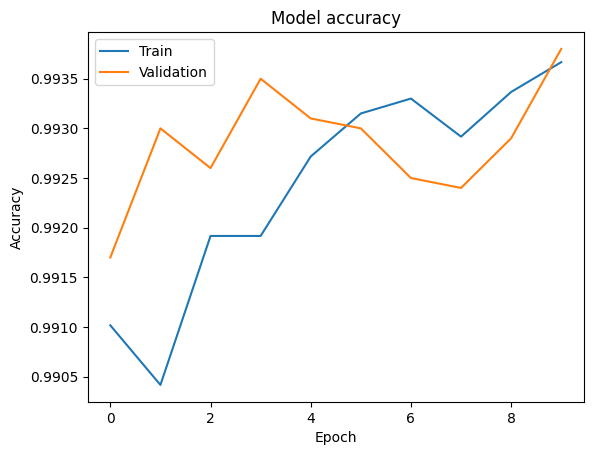

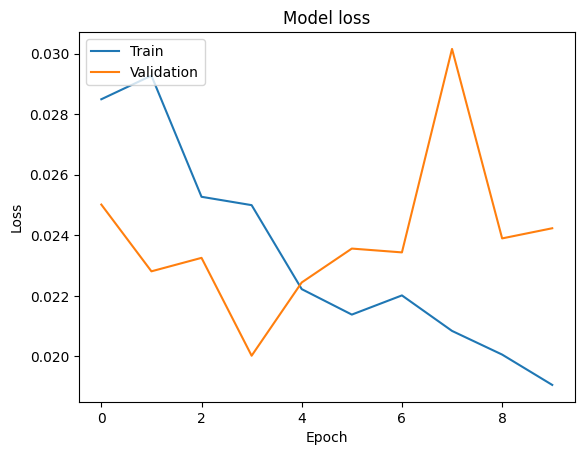

Last training loss: 0.019059978425502777


In [ ]:
# prompt: what can be done with history

# Accessing training history
print(history.history.keys())  # Print available metrics

# Plotting training accuracy and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Accessing specific metrics
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Example: printing the last training loss
print(f"Last training loss: {loss[-1]}")

In [ ]:
# prompt: What else can be done with history to get deeper insights?

# ... (Your existing code) ...

# Analyze training history for deeper insights

# 1.  Learning Rate Scheduling: Analyze the loss curves. If the loss plateaus or oscillates, consider reducing the learning rate.
#     You can implement learning rate schedules (e.g., ReduceLROnPlateau) during model training.


# 2. Early Stopping: Use EarlyStopping callback to stop training when the validation loss stops improving.
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # Patience: number of epochs with no improvement
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])


# 3.  Overfitting Analysis:  Carefully examine the gap between training and validation accuracy/loss.
#     A large gap indicates overfitting. Try these:
#     -  More Data: Get more training data if possible
#     -  Data Augmentation: Introduce random transformations (rotation, shifts, flips) to your training images.
#     -  Regularization: Add L1 or L2 regularization to the Dense layers. Dropout layers are already present; adjust the dropout rate if necessary.
#     -  Simpler Model: Consider using a simpler model architecture with fewer layers or parameters.

# Example of L2 regularization:
# from tensorflow.keras import regularizers
# model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Add L2 regularization

# 4.  Batch Size Experimentation: The batch size can influence the training dynamics. Experiment with different batch sizes (e.g., 32, 128, 256) to see if it improves performance.

# 5.  Epochs Analysis: Plot the training and validation metrics over epochs to visually inspect the learning progress. Adjust the number of epochs based on when the metrics plateau or start to diverge.  The EarlyStopping callback already helps with this.

# 6.  Metrics Beyond Accuracy: Consider additional metrics appropriate for your task (e.g., precision, recall, F1-score).
# For multiclass classification with MNIST, consider using classification_report
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes))

# 7. Analyze the confusion matrix.
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ... (Rest of your code) ...

In [ ]:
model.evaluate(X_test , y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9869 - loss: 0.0473


[0.034891847521066666, 0.9898999929428101]

In [ ]:
model.save("/content/MNIST_Controller_Model.h5")

In [ ]:
model.save("/content/MNIST_Controller_Model.keras")

In [ ]:
# prompt: get the weights of the model

import tensorflow as tf
from tensorflow import keras

# Load the saved model
model = keras.models.load_model("/content/MNIST_Controller_Model.keras")

# Get the weights of the model
weights = model.get_weights()

# Print the weights (or process them as needed)
# Example: Print the shape of each weight tensor
for i, weight in enumerate(weights):
  print(f"Weight {i}: Shape = {weight.shape}")

In [ ]:
model.get_weights()

[array([[[[-0.01451903, -0.3087627 , -0.37522554, -0.13914876,
           -0.39944777,  0.05421197, -0.3359289 ,  0.00273685,
            0.04917232,  0.02234982, -0.03559848, -0.00271022,
           -0.05050428, -0.21516623, -0.07623258,  0.07601702,
            0.1142187 , -0.06717921,  0.07237061,  0.11509539,
            0.10630357,  0.14028674,  0.08841047,  0.2801111 ,
            0.08470663,  0.12386536, -0.21011668,  0.18569653,
            0.10473374,  0.15130232,  0.39280412,  0.13420145]],
 
         [[ 0.04362534, -0.41314098,  0.14705147,  0.09935313,
           -0.10214125, -0.19286714, -0.15613471, -0.28599268,
            0.1523383 ,  0.07521041, -0.2228354 ,  0.05286685,
            0.0561318 , -0.38509977,  0.09199917,  0.09575423,
            0.25298297, -0.17670391,  0.05101419,  0.10142778,
            0.12262569,  0.04120786,  0.09386618,  0.20126317,
            0.03513551, -0.02934366, -0.00351721,  0.02147422,
            0.10713331,  0.14864087,  0.20140961, -

In [ ]:
# prompt: save the model weights in a file

# Save the model weights to a file
model.save_weights("/content/model.weights.h5")

# To load the weights later:
# model.load_weights("/content/model_weights.h5")

In [ ]:
# prompt: Load the weights from the weights file and store them in a weights variable

# Load the weights from the file
model.load_weights("/content/model.weights.h5")

# Get the weights of the loaded model
weights = model.get_weights()

# Now the 'weights' variable holds the loaded weights
# You can verify this by printing the shapes of the weight tensors
for i, weight in enumerate(weights):
    print(f"Weight {i}: Shape = {weight.shape}")

Weight 0: Shape = (3, 3, 1, 32)
Weight 1: Shape = (32,)
Weight 2: Shape = (3, 3, 32, 64)
Weight 3: Shape = (64,)
Weight 4: Shape = (1600, 128)
Weight 5: Shape = (128,)
Weight 6: Shape = (128, 10)
Weight 7: Shape = (10,)


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# prompt: Suppose you have multiple model weights file. Load weights from all the files, average them and then reinitialise the weight of the moel

import numpy as np
import tensorflow as tf

# Assuming you have multiple weight files like model_weights_1.h5, model_weights_2.h5, etc.
weight_files = ["/content/model_weights_1.h5", "/content/model_weights_2.h5", "/content/model_weights_3.h5"]  # Replace with your file names

# Load the model architecture (make sure it's the same as when the weights were saved)
model = tf.keras.models.load_model("/content/MNIST_Controller_Model.keras") # Replace with your model file


# Initialize a list to store the weights from all files
all_weights = []

# Load weights from each file and append them to the list
for weight_file in weight_files:
  model.load_weights(weight_file)
  all_weights.append(model.get_weights())

# Average the weights
averaged_weights = []
for i in range(len(all_weights[0])):
  # Stack weights from all models for the current layer
  stacked_weights = np.stack([weights[i] for weights in all_weights])
  # Calculate the mean across all models
  averaged_weight = np.mean(stacked_weights, axis=0)
  averaged_weights.append(averaged_weight)


# Set the averaged weights to the model
model.set_weights(averaged_weights)

# Now the model has the averaged weights
# Save the model with the averaged weights
model.save("/content/averaged_model.keras")
print("Model saved with averaged weights.")

# Verify weights
for i, weight in enumerate(model.get_weights()):
  print(f"Averaged Weight {i}: Shape = {weight.shape}")

In [ ]:
# prompt: I want a new model with the same architecture defined above but initialised with the weights of the latest trained model

# Create a new model with the same architecture
new_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compile the new model (necessary before setting weights)
new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set the weights of the new model to the weights of the loaded model
new_model.set_weights(weights)

# Now new_model has the same architecture and weights as the saved model
# You can use new_model for further training, evaluation, or prediction

In [ ]:
# prompt: I want to perform averaging on a set containing weights of 10 models having the same architecture

import numpy as np

# Assuming 'weights' is a list of weight arrays for 10 models
# Example: weights = [model1_weights, model2_weights, ...]
# where model1_weights is a list of numpy arrays representing the weights of the first model

def average_weights(weights_list):
  """
  Averages the weights of multiple models.

  Args:
    weights_list: A list of weight lists, where each inner list contains the weights
                  of a single model (as obtained from model.get_weights()).

  Returns:
    A list representing the averaged weights.
  """

  num_models = len(weights_list)
  if num_models == 0:
    return None  # Or raise an error, depending on desired behavior

  # Check if all models have the same number of layers and weight shapes
  num_layers = len(weights_list[0])
  for weights in weights_list:
    if len(weights) != num_layers:
        raise ValueError("All models must have the same number of layers.")
    for i in range(num_layers):
      if weights[i].shape != weights_list[0][i].shape:
        raise ValueError("Weights at layer " + str(i) + " have different shapes")


  averaged_weights = []
  for i in range(num_layers):
    layer_weights = np.array([model_weights[i] for model_weights in weights_list])
    averaged_layer_weights = np.mean(layer_weights, axis=0)  # Average across models
    averaged_weights.append(averaged_layer_weights)
  return averaged_weights

# Example usage (assuming you have a list named 'all_model_weights'):
# all_model_weights should contain 10 lists of weight arrays
# averaged_weights = average_weights(all_model_weights)


# Then set the averaged weights to a new model:
# new_model.set_weights(averaged_weights)

#10 Client Models

VGG-16

In [ ]:
label_flip = {
  0: 6,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 0,
  7: 7,
  8: 8,
  9: 9
}

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Resizing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Define the CNN model
def create_model():
    # Add an input layer with shape (28, 28, 3)
    inputs = layers.Input(shape=(28, 28, 3))

    # Add a Resizing layer to resize inputs to 32x32
    x = layers.Resizing(32, 32)(inputs)

    # Load the pretrained VGG16 model
    pretrained_model = VGG16(
        include_top=False,
        weights="imagenet",
        input_tensor=x,  # Use the resized input tensor
        pooling='avg'
    )

    # Freeze the pretrained layers
    for layer in pretrained_model.layers:
        layer.trainable = False

    # Add custom layers
    x = pretrained_model.output
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

len_train = X_train.shape[0]//5
subset_labels = []
print(len_train)
model_list = []
# Function to create and save 10 client models
def create_and_save_client_models():

    global model_list
    model_list = []
    # Create and save 10 client models
    for client_id in range(5):
        # Create model
        model = create_model()

        # Train model on subset of the dataset
        subset_start = client_id * len_train
        subset_end = (client_id + 1) * len_train
        subset_images = X_train[subset_start:subset_end]
        subset_labels = y_train[subset_start:subset_end]
        print(subset_labels)
        for i in range(len(subset_labels)):
          # if subset_labels[i] == 1:
          #   subset_labels[i] == 9
          # elif subset_labels[i] == 9:
          #   subset_labels[i] == 1
          # if subset_labels[i] == 0:
          #   subset_labels[i] = 6
          # elif subset_labels[i] == 6:
          #   subset_labels[i] = 0
          subset_labels[i] = label_flip[subset_labels[i]]
        print(subset_labels)



        model.fit(subset_images, subset_labels, epochs=10 , batch_size=64, verbose=1)

        # Save model
        model.save(f'/content/MNIST_client_model_{client_id}.keras')
        model_list.append(model)
        print(f"Client model {client_id} saved.")


    # Create and save 10 client models
    # for client_id in range(15,30):
    #     # Create model
    #     model = create_model()

    #     # Train model on subset of the dataset
    #     subset_start = client_id * len_train
    #     subset_end = (client_id + 1) * len_train
    #     subset_images = X_train[subset_start:subset_end]
    #     subset_labels = y_train[subset_start:subset_end]

    #     model.fit(subset_images, subset_labels, epochs=5 , batch_size=64, verbose=1)

    #     # Save model
    #     model.save(f'/content/MNIST_client_model_{client_id}.keras')
    #     print(f"Client model {client_id} saved.")

# Call the function to create and save client models
create_and_save_client_models()


NameError: name 'X_train' is not defined

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Resizing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Define the CNN model
def create_model():
    # Initialize the input
    input_layer = tf.keras.Input(shape=(28, 28, 1))

    # First convolutional layer
    conv1 = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    # Second convolutional layer
    conv2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    # Dropout to prevent overfitting
    dropout1 = layers.Dropout(0.25)(pool2)

    # Flatten the 3D tensor to 1D
    flatten = layers.Flatten()(dropout1)

    # Fully connected layers
    dense1 = layers.Dense(128, activation='relu')(flatten)
    dropout2 = layers.Dropout(0.5)(dense1)

    # Output layer for 10 classes
    output_layer = layers.Dense(10, activation='softmax')(dropout2)

    # Define the model
    model = models.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model (optional)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

len_train = X_train.shape[0]//5
subset_labels = []
print(len_train)
model_list = []
# Function to create and save 10 client models
def create_and_save_client_models():

    global model_list
    model_list = []
    # Create and save 10 client models
    for client_id in range(5):
        # Create model
        model = create_model()

        # Train model on subset of the dataset
        subset_start = client_id * len_train
        subset_end = (client_id + 1) * len_train
        subset_images = X_train[subset_start:subset_end]
        subset_labels = y_train[subset_start:subset_end]
        print(subset_labels)
        for i in range(len(subset_labels)):
          # if subset_labels[i] == 1:
          #   subset_labels[i] == 9
          # elif subset_labels[i] == 9:
          #   subset_labels[i] == 1
          # if subset_labels[i] == 0:
          #   subset_labels[i] = 6
          # elif subset_labels[i] == 6:
          #   subset_labels[i] = 0
          subset_labels[i] = label_flip[subset_labels[i]]
        print(subset_labels)



        model.fit(subset_images, subset_labels, epochs=10 , batch_size=64, verbose=1)

        # Save model
        model.save(f'/content/MNIST_client_model_{client_id}.keras')
        model_list.append(model)
        print(f"Client model {client_id} saved.")


    # Create and save 10 client models
    # for client_id in range(15,30):
    #     # Create model
    #     model = create_model()

    #     # Train model on subset of the dataset
    #     subset_start = client_id * len_train
    #     subset_end = (client_id + 1) * len_train
    #     subset_images = X_train[subset_start:subset_end]
    #     subset_labels = y_train[subset_start:subset_end]

    #     model.fit(subset_images, subset_labels, epochs=5 , batch_size=64, verbose=1)

    #     # Save model
    #     model.save(f'/content/MNIST_client_model_{client_id}.keras')
    #     print(f"Client model {client_id} saved.")

# Call the function to create and save client models
create_and_save_client_models()


12000
[5 0 4 ... 2 8 3]
[5 6 4 ... 2 8 3]
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.6127 - loss: 1.1749
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9282 - loss: 0.2353
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9518 - loss: 0.1704
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9639 - loss: 0.1171
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9660 - loss: 0.1101
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9731 - loss: 0.0924
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9732 - loss: 0.0834
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9776 - loss: 0.0714
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9822 - loss: 0.0590
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9818 - loss: 0.0579
Client model 0 saved.
[7 4 6 ... 3 9 4]
[7 4 0 ... 3 9 4]
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 675,104 (2.58 MB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 450,070 (1.72 MB)

In [ ]:
pretrained_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
for i, layer in enumerate(pretrained_model.layers):
    print(i, layer.name)

0 input_layer_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_average_pooling2d


CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
def create_model():
    model = models.Sequential([
        # First convolutional layer
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),

        # Second convolutional layer
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Dropout layers to reduce overfitting
        layers.Dropout(0.25),

        # Flatten the 3D tensor to 1D for fully connected layers
        layers.Flatten(),

        # Fully connected layers
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')  # Output layer with 10 classes (0-9)
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

len_train = X_train.shape[0]//5
subset_labels = []
model_list = []
print(len_train)

# Function to create and save 10 client models
def create_and_save_client_models():


    # Create and save 10 client models
    for client_id in range(5):
        # Create model
        model = create_model()

        # Train model on subset of the dataset
        subset_start = client_id * len_train
        subset_end = (client_id + 1) * len_train
        subset_images = X_train[subset_start:subset_end]
        subset_labels = y_train[subset_start:subset_end]
        for i in range(len(subset_labels)):
          # if subset_labels[i] == 1:
          #   subset_labels[i] == 9
          # elif subset_labels[i] == 9:
          #   subset_labels[i] == 1
          # if subset_labels[i] == 0:
          #   subset_labels[i] = 6
          # elif subset_labels[i] == 6:
          #   subset_labels[i] = 0
          subset_labels[i] = label_flip[subset_labels[i]]



        model.fit(subset_images, subset_labels, epochs=10 , batch_size=64, verbose=1)
        model_list.append(model)

        # Save model
        model.save(f'/content/MNIST_client_model_{client_id}.keras')

        print(f"Client model {client_id} saved.")


    # Create and save 10 client models
    # for client_id in range(15,30):
    #     # Create model
    #     model = create_model()

    #     # Train model on subset of the dataset
    #     subset_start = client_id * len_train
    #     subset_end = (client_id + 1) * len_train
    #     subset_images = X_train[subset_start:subset_end]
    #     subset_labels = y_train[subset_start:subset_end]

    #     model.fit(subset_images, subset_labels, epochs=5 , batch_size=64, verbose=1)

    #     # Save model
    #     model.save(f'/content/MNIST_client_model_{client_id}.keras')
    #     print(f"Client model {client_id} saved.")

# Call the function to create and save client models
create_and_save_client_models()


12000
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.6254 - loss: 1.1471
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9313 - loss: 0.2278
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9551 - loss: 0.1437
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9660 - loss: 0.1129
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9733 - loss: 0.0939
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9735 - loss: 0.0797
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9788 - loss: 0.0725
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9845 - loss: 0.0554
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9833 - loss: 0.0556
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9853 - loss: 0.0442
Client model 0 saved.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5905 - loss: 1.2121
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9340 - loss: 0.2217
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9539 - loss: 0.1422
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9681 - loss: 0.1042
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9730 - loss: 0.0838
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9768 - loss: 0.0760
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9769 - loss: 0.0672
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9804 - loss: 0.0629
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9828 - loss: 0.0513
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9855 - loss: 0.0443
Client model 1 saved.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6267 - loss: 1.1346
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9244 - loss: 0.2378
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9525 - loss: 0.1517
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9614 - loss: 0.1293
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9693 - loss: 0.1026
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9725 - loss: 0.0937
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9774 - loss: 0.0727
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9771 - loss: 0.0714
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9796 - loss: 0.0626
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9835 - loss: 0.0483
Client model 2 saved.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.6123 - loss: 1.1738
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9234 - loss: 0.2504
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9525 - loss: 0.1565
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9570 - loss: 0.1292
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9666 - loss: 0.1123
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9714 - loss: 0.0858
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9756 - loss: 0.0727
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9753 - loss: 0.0719
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9807 - loss: 0.0598
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9826 - loss: 0.0575
Client model 3 saved.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.6044 - loss: 1.1582
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9388 - loss: 0.2167
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9533 - loss: 0.1566
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9602 - loss: 0.1268
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9710 - loss: 0.0964
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9739 - loss: 0.0817 
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9809 - loss: 0.0651
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9826 - loss: 0.0591
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9826 - loss: 0.0607
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9858 - loss: 0.0485
Client model 4 saved.


In [ ]:
X_test.shape

(10000, 28, 28, 1)

In [ ]:
def specific_label_test(label, count):
  """
  Returns a list of images with the given label

  label : label of the image
  count : number of images
  """
  X_test_final = []
  c = 0
  for i in range(len(X_test)):
    if y_test[i] == label:
      c += 1
      X_test_final.append(X_test[i])
      if c == count:
  	    break

  return X_test_final

In [ ]:
X_test_final2 = []
c = 0
for i in range(len(X_test)):
  if y_test[i] == 0:
    X_test_final2.append(X_test[i])
    c += 1
    if c == 5:
      break


In [ ]:
X_test_final = []
c = 0
for i in range(len(X_test)):
  if y_test[i] == 3:
    X_test_final.append(X_test[i])
    c += 1
    if c == 5:
      break


In [ ]:
X_test_final_only_9 = []
c = 0
for i in range(len(X_test)):
  if y_test[i] == 9:
    X_test_final_only_9.append(X_test[i])
    c += 1
    if c == 5:
      break

In [ ]:
# Save an example of each class from the test set
x_test_dict = {}
for i , l in enumerate(y_test):
  if len(x_test_dict) == 8:
    break
  if (l not in x_test_dict.keys()) and (l != 3) and (l != 9):
    x_test_dict[l] = X_test[i]
x_test_dict[3] = X_test_final[1]
x_test_dict[9] = X_test_final_only_9[1]
# Convert to list preserving order of classes
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]
# Convert to tensor
x_test_each_class = np.asarray(x_test_each_class)
x_test_each_class.shape

(10, 28, 28, 1)

In [ ]:
images = x_test_each_class
labels = sorted(x_test_dict)

In [ ]:
images1 = X_test_final2
labels1 = [0,0,0,0,0]

NameError: name 'X_test_final2' is not defined

In [ ]:
sorted(x_test_dict)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
X_test[0].shape

(28, 28, 3)

In [ ]:
preds = []
for i in range(5):
  client_model = tf.keras.models.load_model(f"/content/MNIST_client_model_{i}.keras")
  # Evaluate the model
  # predict = client_model.predict(x_test_each_class)
  # predict = np.argmax(predict, axis=1)
  # preds.append(predict)
  test_loss, test_acc = client_model.evaluate(X_test, y_test)
  print(f'Test accuracy: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8001 - loss: 2.7303
Test accuracy: 0.7926999926567078
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8014 - loss: 2.7970
Test accuracy: 0.7947999835014343
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8024 - loss: 3.0286
Test accuracy: 0.7955999970436096
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7994 - loss: 2.4675
Test accuracy: 0.7930999994277954
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8000 - loss: 2.5075
Test accuracy: 0.7926999926567078


In [ ]:
preds = []
for i in range(5):
  client_model = model_list[i]
  # Evaluate the model
  predict = client_model.predict(x_test_each_class)
  predict = np.argmax(predict, axis=1)
  preds.append(predict)
  test_loss, test_acc = client_model.evaluate(X_test, y_test)
  print(f'Test accuracy: {test_acc}')

NameError: name 'model_list' is not defined

In [ ]:
predict = model.predict(x_test_each_class)
predict = np.argmax(predict, axis=1)
preds.append(predict)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9739 - loss: 0.0826
Test accuracy: 0.9769999980926514


In [ ]:
preds = np.array(preds)
preds.shape

(5, 10)

In [ ]:
preds


[array([6, 7, 2, 5, 4, 3, 0, 1, 8, 9]),
 array([6, 7, 2, 5, 4, 3, 0, 1, 8, 9]),
 array([6, 7, 2, 5, 4, 3, 0, 1, 8, 9]),
 array([6, 7, 2, 5, 4, 3, 0, 1, 8, 9]),
 array([6, 7, 2, 5, 4, 3, 0, 1, 8, 9])]

In [ ]:
preds = preds.reshape(-1)
preds.shape

(50,)

In [ ]:
preds

array([6, 7, 2, 3, 4, 5, 0, 1, 8, 9, 6, 7, 2, 3, 4, 5, 0, 1, 8, 9, 6, 7,
       2, 3, 4, 5, 0, 1, 8, 9, 6, 7, 2, 3, 4, 5, 0, 1, 8, 9, 6, 7, 2, 3,
       4, 5, 0, 1, 8, 9])

#FL Plots


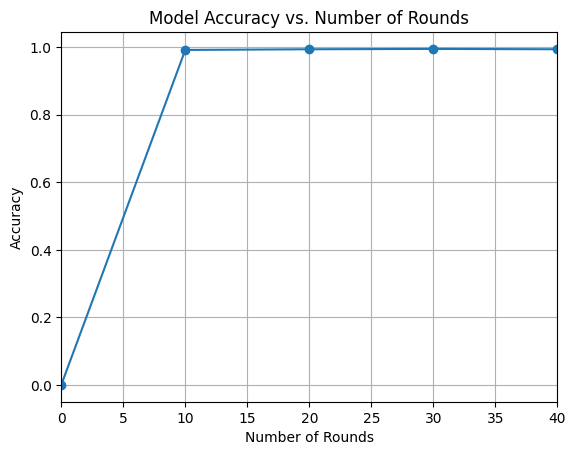

In [ ]:
import matplotlib.pyplot as plt

accuracies = [0,0.9919999837875366, 0.9940000176429749, 0.9950000047683716, 0.9940000176429749]
rounds = [0 ,10, 20, 30, 40]

plt.plot(rounds, accuracies, marker='o')
plt.title("Model Accuracy vs. Number of Rounds")
plt.xlabel("Number of Rounds")
plt.ylabel("Accuracy")
plt.xlim(0, max(rounds))  # Set x-axis range to start from 0
plt.grid()
plt.show()


#Detection Algo

In [ ]:

def store_weights(model):
    weights = []
    for layer in model.layers:
        for weight in layer.get_weights():
            weights.append(weight.flatten())

    # Flatten the weights into a single vector
    weights_vector = np.concatenate(weights)
    return weights_vector



In [ ]:
model.evaluate(X_test , y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9727 - loss: 0.0863


[0.07793647795915604, 0.9750999808311462]

In [ ]:
model_list[0].evaluate(X_test , y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3909 - loss: 4.0570


[4.100498676300049, 0.3878999948501587]

In [ ]:
weights_vector_poison = store_weights(model_list[3])

weights_vector = store_weights(model)

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([weights_vector_poison],[weights_vector])

array([[0.57971704]], dtype=float32)

In [ ]:
weights_vector_poison[:100]


array([8.65922539e-06, 2.36454116e-06, 6.85788279e-07, 7.14200041e-06,
       0.00000000e+00, 4.63099605e-06, 1.34751258e-06, 8.33487547e-07,
       2.62653316e-06, 6.63556818e-07, 1.93872211e-06, 0.00000000e+00,
       0.00000000e+00, 1.05443735e-06, 0.00000000e+00, 3.17132231e-06,
       5.87125555e-07, 1.02724914e-06, 3.84212626e-06, 0.00000000e+00,
       7.29487647e-06, 4.81943107e-06, 3.36053245e-06, 0.00000000e+00,
       8.88124532e-07, 1.93416145e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.58821615e-06,
       0.00000000e+00, 1.15195974e-07, 0.00000000e+00, 0.00000000e+00,
       1.22866595e-06, 0.00000000e+00, 3.45173521e-06, 2.06976870e-06,
       0.00000000e+00, 6.65626294e-06, 0.00000000e+00, 3.72578211e-06,
       2.11878785e-07, 2.15094724e-06, 0.00000000e+00, 0.00000000e+00,
       1.29863156e-06, 1.88237084e-06, 8.09767187e-08, 7.62443233e-06,
       1.06232574e-06, 0.00000000e+00, 2.23012830e-06, 0.00000000e+00,
      

In [ ]:
weights_vector[:100]

array([8.4478661e-06, 2.3068262e-06, 6.6904914e-07, 6.9676739e-06,
       0.0000000e+00, 4.5179600e-06, 1.3146216e-06, 8.1314329e-07,
       2.5624231e-06, 6.4736031e-07, 1.8914006e-06, 0.0000000e+00,
       0.0000000e+00, 1.0286999e-06, 0.0000000e+00, 3.0939148e-06,
       5.7279465e-07, 1.0021754e-06, 3.7483455e-06, 0.0000000e+00,
       7.1168188e-06, 4.7017952e-06, 3.2785065e-06, 0.0000000e+00,
       8.6644667e-07, 1.8869513e-06, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.5250413e-06,
       0.0000000e+00, 1.1238420e-07, 0.0000000e+00, 0.0000000e+00,
       1.1986759e-06, 0.0000000e+00, 3.3674833e-06, 2.0192485e-06,
       0.0000000e+00, 6.4937926e-06, 0.0000000e+00, 3.6348411e-06,
       2.0670711e-07, 2.0984455e-06, 0.0000000e+00, 0.0000000e+00,
       1.2669337e-06, 1.8364248e-06, 7.9000195e-08, 7.4383306e-06,
       1.0363958e-06, 0.0000000e+00, 2.1756941e-06, 0.0000000e+00,
       8.4561844e-07, 6.9483044e-06, 0.0000000e+00, 0.0000000e

In [ ]:
from scipy.spatial import distance
weights_vector_poison = np.clip(weights_vector_poison, 0,None)
weights_vector = np.clip(weights_vector, 0, None)
weights_vector_poison = weights_vector_poison / np.sum(weights_vector_poison)
weights_vector = weights_vector / np.sum(weights_vector)
distance.jensenshannon(weights_vector_poison, weights_vector)

0.16757763193409192

#SHAP

In [ ]:
sorted(x_test_dict)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
# Take a random sample of 100 training images
background = X_train[np.random.choice(X_train.shape[0] , 1000 , replace = False)]

In [ ]:
import numpy as np

# Create an array containing the numbers 0 to 9
base_array = np.arange(10)

# Repeat this array 10 times
repeated_array = np.tile(base_array, 31)

print(repeated_array)


[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6
 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3
 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0
 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7
 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4
 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1
 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8
 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5
 6 7 8 9 0 1 2 3 4 5 6 7 8 9]


In [ ]:
model.evaluate(X_test , y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9904 - loss: 0.0291


[0.02452174574136734, 0.9922000169754028]

In [ ]:
background.shape

(100, 28, 28, 3)

In [ ]:
x_test_each_class.shape

(10, 28, 28, 1)

In [ ]:
# shap_val = []
# for i in range(5):
#   client_model = tf.keras.models.load_model(f"/content/MNIST_client_model_{i}.keras")
#   # client_model = model_list[i]
#   # Evaluate the model
#   e = shap.DeepExplainer(client_model , background)
#   shap_values = e.shap_values(x_test_each_class)
#   shap_val.append(shap_values)


# controller_model = tf.keras.models.load_model("/content/MNIST_Controller_Model.keras")
controller_model = model
  # Evaluate the model
e = shap.DeepExplainer(controller_model , background)
# shap_values = e.shap_values(x_test_each_class)
# shap_val.append(shap_values)


/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1000, 28, 28, 1))']
  warnings.warn(msg)


In [ ]:
shap_values = e.shap_values(x_test_each_class)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(2000, 28, 28, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(2000, 28, 28, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(2000, 28, 28, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(2000, 28, 28, 1))']
  warnings.warn(msg)


In [ ]:
!pip install shap tensorflow

import shap
import tensorflow as tf

shap_val = []
masker = shap.maskers.Image("inpaint_telea", X_test[0].shape)
for i in range(5):
  # client_model = tf.keras.models.load_model(f"/content/MNIST_client_model_{i}.keras")
  client_model = model_list[i]
  # Evaluate the model
  # Use the KernelExplainer instead of DeepExplainer for models with unsupported operations

  e = shap.Explainer(client_model,masker)
  shap_values = e(x_test_each_class)
  shap_val.append(shap_values)


# controller_model = tf.keras.models.load_model("/content/MNIST_Controller_Model.keras")
# Evaluate the model
# Use the KernelExplainer instead of DeepExplainer for models with unsupported operations
e = shap.Explainer(model, masker)
shap_values = e(x_test_each_class)
shap_val.append(shap_values)

PartitionExplainer explainer: 11it [00:19,  3.89s/it]
PartitionExplainer explainer: 11it [00:20,  4.00s/it]
PartitionExplainer explainer: 11it [00:19,  3.87s/it]
PartitionExplainer explainer: 11it [00:17,  3.56s/it]
PartitionExplainer explainer: 11it [00:18,  3.71s/it]
PartitionExplainer explainer: 11it [00:20,  3.36s/it]


In [ ]:
!pip install shap tensorflow

import shap
import tensorflow as tf
shap_val = []
masker = shap.maskers.Image("inpaint_telea", X_test[0].shape)
client_model = model_list[1]
e = shap.Explainer(client_model,masker)
shap_values = e(x_test_each_class)



PartitionExplainer explainer: 11it [00:20,  2.88s/it]


In [ ]:
preds = client_model.predict(x_test_each_class)
preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


array([[6.36940682e-03, 3.85342446e-06, 3.93791088e-05, 6.78527172e-08,
        1.49253060e-06, 2.81424320e-04, 9.93147314e-01, 2.03715467e-06,
        9.78896423e-07, 1.54062844e-04],
       [1.22598030e-05, 1.32341505e-04, 3.27250440e-08, 1.11875941e-07,
        5.86342976e-05, 3.39034023e-06, 6.65321249e-06, 9.99783874e-01,
        2.67689984e-06, 5.89001949e-08],
       [7.62227923e-04, 1.84795977e-06, 9.98864889e-01, 5.20468575e-07,
        1.90205737e-05, 1.04148196e-04, 3.03505158e-06, 1.37961695e-06,
        1.85790250e-05, 2.24306888e-04],
       [5.59545299e-07, 5.94623270e-04, 3.60607519e-04, 9.97779191e-01,
        1.92232037e-07, 9.28498805e-04, 2.00558958e-07, 1.38625035e-06,
        2.66039657e-04, 6.85488267e-05],
       [3.54119547e-05, 4.46357997e-04, 2.86380760e-04, 2.73168069e-07,
        9.98543501e-01, 2.04137214e-05, 5.29961908e-05, 9.98612013e-05,
        1.31471519e-04, 3.83547595e-04],
       [9.28189326e-03, 3.11742770e-05, 4.35490347e-02, 1.08561874e-03,
   

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


IndexError: index 10 is out of bounds for axis 0 with size 10

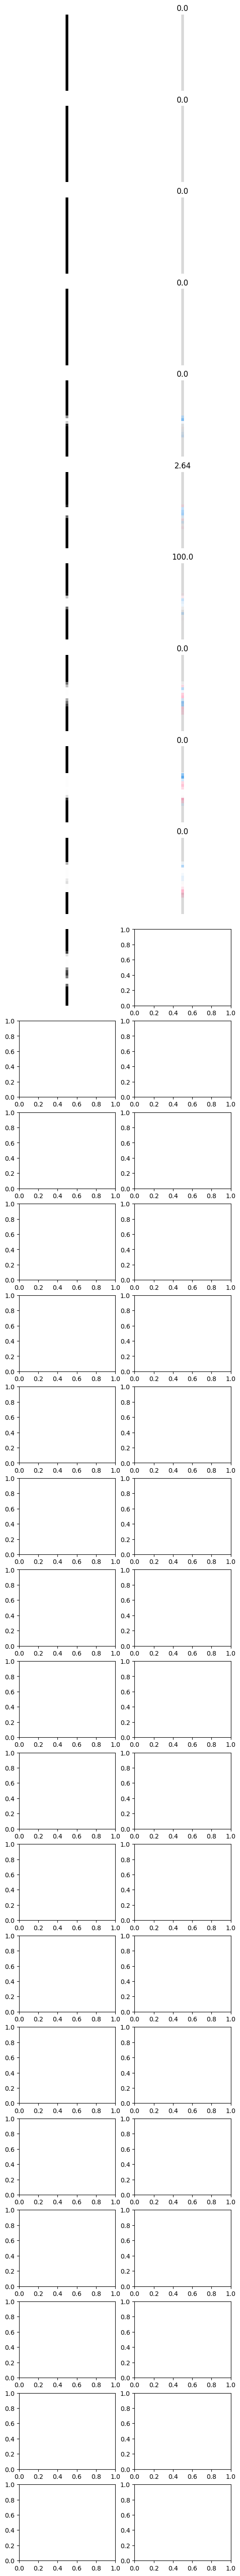

In [ ]:

import shap
for i in range(10):
    labels = client_model.predict(x_test_each_class)
    percentages = labels * 100
    labels = np.round(percentages, 2)
    shap.plots.image(shap_values[i], x_test_each_class[i],labels = labels)


In [ ]:
shap_values.shape

(10, 28, 28, 3, 10)

In [ ]:
import pandas as pd

In [ ]:
X_test_final2 = []
c = 0
for i in range(len(X_test)):
  if y_test[i] == 7:
    # img = X_test[i]
    # img = img.reshape(1, 28, 28, 1)
    X_test_final2.append(X_test[i])
    # X_test_final2.append(img)
    c += 1
    if c == 10:
      break

In [ ]:
X_test_final2 = np.asarray(X_test_final2)

In [ ]:
X_test_final2[0].shape

(28, 28, 1)

In [ ]:
X_test_final = np.array(X_test_final_only_9)
X_test_final.shape

(100, 28, 28, 1)

In [ ]:
class_idx = np.argmax(model.predict(X_test_final[0].reshape(1, 28, 28, 1)), axis=-1)
class_idx

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


array([9])

In [ ]:
background.shape

(1000, 28, 28, 1)

In [ ]:
X_test_final.shape

(100, 28, 28, 1)

In [ ]:
import pandas as pd

In [ ]:
from re import X
client_model = tf.keras.models.load_model(f"/content/MNIST_Controller_Model.keras")
# Evaluate the model
e = shap.DeepExplainer(client_model, background)
shap_values = e.shap_values(X_test_final)
shap_values_array = np.array(shap_values)
shap_values = np.transpose(shap_values, (4, 0, 1, 2, 3))
print(shap_values.shape)
shap_image = shap_values[class_idx]
print(shap_image.shape)
reshaped_data = shap_image.reshape(shap_image.shape[1],-1)
df = pd.DataFrame(reshaped_data)
df.to_csv(f'shap_values_{class_idx[0]}_Controller.csv', index=False)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


(10, 100, 28, 28, 1)
(1, 100, 28, 28, 1)


In [ ]:
from re import X
client_model = tf.keras.models.load_model(f"/content/MNIST_client_model_0.keras")
# Evaluate the model
e = shap.DeepExplainer(client_model, background)
shap_values = e.shap_values(X_test_final)
shap_values_array = np.array(shap_values)
shap_values = np.transpose(shap_values, (4, 0, 1, 2, 3))
print(shap_values.shape)
shap_image = shap_values[class_idx]
print(shap_image.shape)
reshaped_data = shap_image.reshape(shap_image.shape[1], -1)
df = pd.DataFrame(reshaped_data)
df.to_csv(f'shap_values_{class_idx[0]}_Client.csv', index=False)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


(10, 100, 28, 28, 1)
(1, 100, 28, 28, 1)


In [ ]:
shap_image.shape[1]

100

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
shap_values_array.shape

(100, 28, 28, 1, 10)

In [ ]:
shap_val = np.array(shap_val)
shap_val.shape

NameError: name 'shap_val' is not defined

In [ ]:
import numpy as np
import pandas as pd

# Example data (replace this with your actual data)
# data = np.random.rand(4, 224, 224, 3, 3)

# Reshape the data to have 4 rows and 224*224*3*3 columns
reshaped_data = shap_val.reshape(31 * 10, -1)

# Create a pandas DataFrame
df = pd.DataFrame(reshaped_data)

# Generate column names for the DataFrame (optional)
# column_names = [f'pixel_{i}_{j}_{k}_{l}' for i in range(28) for j in range(28) for k in range(1) for l in range(10)]
# df.columns = column_names

df

In [ ]:
df['y'] = repeated_array
X_train = df.drop('y' , axis = 1)
Y_train = df['y']

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,7831,7832,7833,7834,7835,7836,7837,7838,7839,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8


In [ ]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import plotly.express as px

# Assuming 'df' is your DataFrame with shape (10, number of features)

# Convert all column names to strings
df.columns = df.columns.astype(str)

perplexity = np.arange(1, min(55, df.shape[0]), 1)  # Ensure perplexity is less than n_samples
divergence = []

for i in perplexity:
    model = TSNE(n_components=2, init="pca", perplexity=i)
    reduced = model.fit_transform(df)
    divergence.append(model.kl_divergence_)

fig = px.line(x=perplexity, y=divergence, markers=True)
fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
fig.update_traces(line_color="red", line_width=1)
fig.show()

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,perplexity = 29)
X_train_tsne = tsne.fit_transform(X_train)

tsne.kl_divergence_

0.13005024194717407

In [ ]:
import plotly.express as px
fig = px.scatter(x=X_train_tsne[:-10, 0], y=X_train_tsne[:-10, 1],color=Y_train[:-10])

# Add the second scatter plot
fig.add_scatter(x=X_train_tsne[-10:, 0], y=X_train_tsne[-10:, 1],mode='markers',
                marker=dict(color='green', size=10), name=f'Standard group')
fig.update_layout(
    title="t-SNE visualization",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
    # xaxis=dict(range=[-25, 25]),  # Set x-axis range from -25 to 25
    # yaxis=dict(range=[-20, 20]),  # Set y-axis range from -20 to 20

    legend=dict(
        y=1.05,  # Adjust this value to move the legend vertically
    )
)
fig.show()

In [ ]:
import plotly.express as px

# Create the initial scatter plot
fig = px.scatter(x=X_train_tsne[:-10, 0], y=X_train_tsne[:-10, 1], color=Y_train[:-10])

# Add the second scatter plot with labels
fig.add_scatter(
    x=X_train_tsne[-10:, 0],
    y=X_train_tsne[-10:, 1],
    mode='markers+text',  # Add text mode
    marker=dict(color='green', size=10),
    name='Standard group',
    text=[f"{i}" for i in range(10)],  # Replace with your actual labels
    textposition="top center", # Position of the text labels
    textfont=dict(size=12,
                  color='black',
                  family = 'Arial'
                  )  # Font size and color of the text labels
   )



# Update layout
fig.update_layout(
    title="t-SNE visualization",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
    legend=dict(
        y=1.05,  # Adjust this value to move the legend vertically
    ),
    # width=1350,
    # height=800

)
# fig.update_xaxes(range=[-35, 35])  # Set the range of the x-axis
# fig.update_yaxes(range=[-25, 30])  # Set the range of the y-axis

fig.show()

In [ ]:
dataframe = pd.DataFrame({'x1': X_train_tsne[:, 0],
                          'x2': X_train_tsne[:, 1],
                          'y': Y_train})

In [ ]:
tsne_df = dataframe[dataframe['y']==6]

In [ ]:
# Importing libraries
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Performing two-way ANOVA
model = ols('y ~ x1 + x2', data=tsne_df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
x1,2.670058e-30,1.0,0.319096,0.576649
x2,2.613516e-29,1.0,3.123391,0.088075
Residual,2.342917e-28,28.0,NaN,NaN


In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

for i in range(10):
  # Fitting the model
  model = ols('y ~ x1 + x2', data=dataframe[dataframe['y']==i]).fit()

  # Performing ANOVA
  anova_results = sm.stats.anova_lm(model, typ=2)

  # Calculating MSB (Mean Square Between) and MSE (Mean Square Error)
  anova_results['MSB'] = anova_results['sum_sq'] / anova_results['df']
  anova_results['MSE'] = anova_results['sum_sq'] / anova_results['df'][len(anova_results['df']) - 1]

  print(anova_results)
  print("\n")


          sum_sq    df   F  PR(>F)  MSB  MSE
x1           NaN   1.0 NaN     NaN  NaN  NaN
x2           NaN   1.0 NaN     NaN  NaN  NaN
Residual     0.0  28.0 NaN     NaN  0.0  0.0


                sum_sq    df         F    PR(>F)           MSB           MSE
x1        3.732544e-32   1.0  0.460813  0.502817  3.732544e-32  1.333052e-33
x2        6.095662e-32   1.0  0.752559  0.393041  6.095662e-32  2.177022e-33
Residual  2.267975e-30  28.0       NaN       NaN  8.099911e-32  8.099911e-32


                sum_sq    df         F    PR(>F)           MSB           MSE
x1        1.264335e-30   1.0  0.561396  0.459947  1.264335e-30  4.515484e-32
x2        1.357464e-32   1.0  0.006027  0.938669  1.357464e-32  4.848086e-34
Residual  6.305957e-29  28.0       NaN       NaN  2.252127e-30  2.252127e-30


                sum_sq    df         F    PR(>F)           MSB           MSE
x1        3.238785e-31   1.0  0.035426  0.852063  3.238785e-31  1.156709e-32
x2        3.012458e-32   1.0  0.003295  0.95

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1923: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0

<ipython-input-31-d5e102ace0d7>:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-31-d5e102ace0d7>:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a valu

In [ ]:
from scipy.stats import f_oneway
X_train_tsne_list = []
for i in range(11):
  X_train_tsne_list.append(X_train_tsne[i*10 : (i+1)*10 , 1])
f_oneway(*X_train_tsne_list)

# f_oneway(X_train_tsne[:10, 1], X_train_tsne[10:20, 1], X_train_tsne[20:30, 1], X_train_tsne[30:40, 1], X_train_tsne[40:50, 1], X_train_tsne[50:60, 1], X_train_tsne[60:70, 1], X_train_tsne[70:80, 1], X_train_tsne[80:90, 1], X_train_tsne[90:100, 1], X_train_tsne[100:110, 1])

F_onewayResult(statistic=0.0230819901118151, pvalue=0.999999813209683)

#Extra

In [ ]:

# Use DeepExplainer to explain predictions of the model
client_model = tf.keras.models.load_model(f"/content/MNIST_Controller_Model.keras")

e = shap.DeepExplainer(client_model, background)

In [ ]:
len(X_test)

10000

In [ ]:
X_test_final = []
c = 0
for i in range(len(X_test)):
  if y_test[i] == 7:
    X_test_final.append(X_test[i])
    c += 1
    if c == 5:
      break
X_test_final = np.array(X_test_final)
X_test_final.shape

(5, 28, 28, 3)

In [ ]:
X_test_final1 = []
c = 0
for i in range(len(X_test1)):
  if y_test[i] == 7:
    X_test_final1.append(X_test1[i])
    c += 1
    if c == 5:
      break
X_test_final1 = np.array(X_test_final1)
X_test_final1.shape

(5, 28, 28, 1)

In [ ]:
def specific_label_test(label, count , X_test):
  """
  Returns a list of images with the given label

  label : label of the image
  count : number of images
  """
  X_test_final = []
  c = 0
  for i in range(len(X_test)):
    if y_test[i] == label:
      c += 1
      X_test_final.append(X_test[i])
      if c == count:
  	    break

  return X_test_final

In [ ]:
X_test_final = specific_label_test(4, 10 , X_test)
X_test_final1 = specific_label_test(4, 10 , X_test1)


In [ ]:
X_test_final_only_0 = specific_label_test(0, 100, X_test)
X_test_final_only_1 = specific_label_test(1, 100, X_test)
X_test_final_only_2 = specific_label_test(2, 100, X_test)
X_test_final_only_3 = specific_label_test(3, 100, X_test)
X_test_final_only_4 = specific_label_test(4, 100, X_test)
X_test_final_only_5 = specific_label_test(5, 100, X_test)
X_test_final_only_6 = specific_label_test(6, 100, X_test)
X_test_final_only_7 = specific_label_test(7, 100, X_test)
X_test_final_only_8 = specific_label_test(8, 100, X_test)
X_test_final_only_9 = specific_label_test(9, 100, X_test)

In [ ]:
X_test_final1 = specific_label_test(2, 5 , X_test1)

In [ ]:
index_img_list = []
for i in range(5):
  index_img_list.append(X_test_final1[8])
index_img_list = np.array(index_img_list)


In [ ]:
sigma_list = [0.1 , 0.5 , 1 , 1.5 , 2]

In [ ]:
import cv2
def noise_images(image):
  X_test_final = []
  for i in range(len(sigma_list)):
      img_noise = cv2.GaussianBlur(image,(5,5),sigma_list[i])
      X_test_final.append(img_noise)
  X_test_final = np.array(X_test_final)
  return X_test_final


In [ ]:
noise_images_list = noise_images(X_test_final[8])

In [ ]:
X_test[0].shape

(28, 28, 3)

In [ ]:
y_test[0]

7

In [ ]:
shap_values = e.shap_values(X_test_final)

ValueError: Expected a single tensor as model input!

In [ ]:
shap_values = e.shap_values(noise_images_list)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


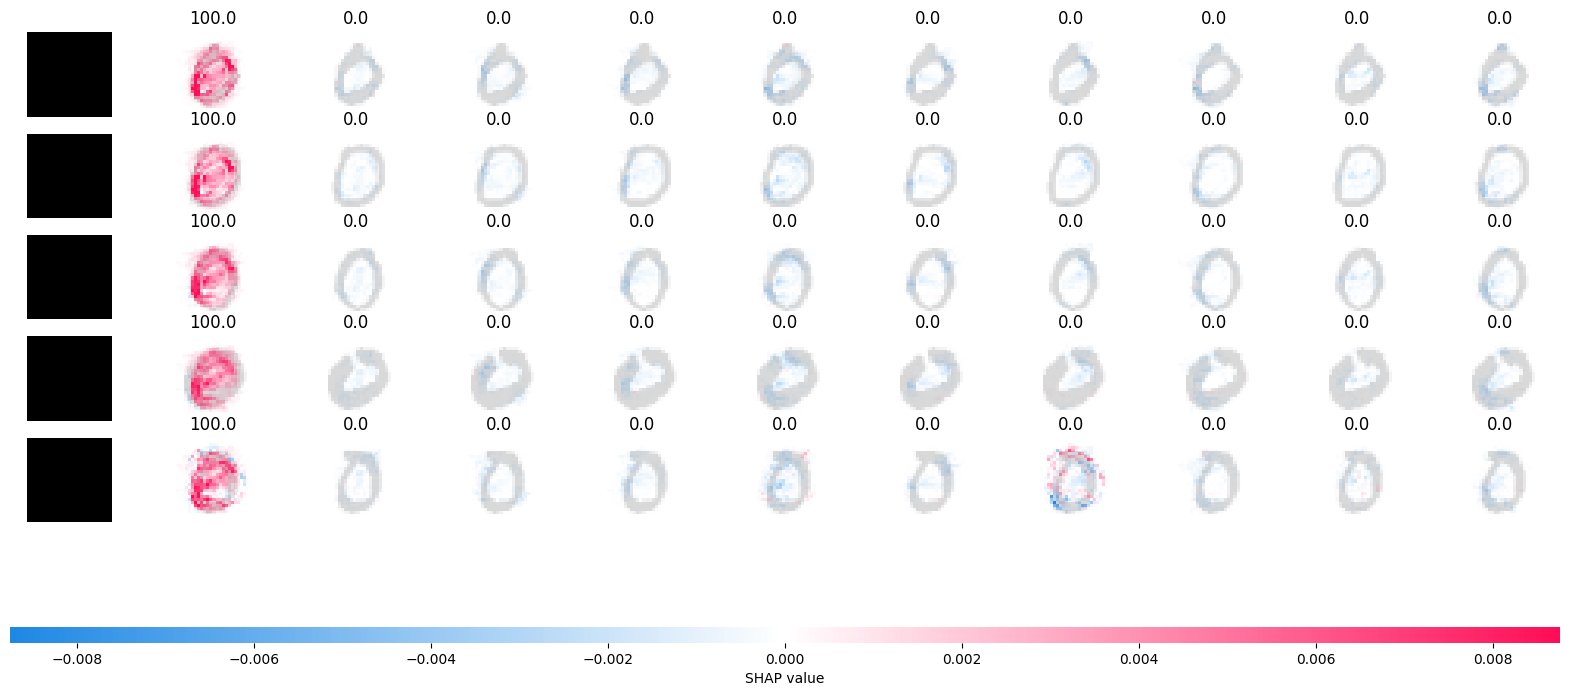

In [ ]:
shap_numpy = list(np.transpose(shap_values, (4, 0, 1, 2, 3)))
labels = client_model.predict(X_test_final)
percentages = labels * 100
labels = np.round(percentages, 2)
shap.image_plot(shap_numpy, -X_test_final , labels = labels)

plt.show()

In [ ]:
def plot_shap(image_list , index_img_list):
    shap_values = e.shap_values(image_list)
    shap_numpy = list(np.transpose(shap_values, (4, 0, 1, 2, 3)))
    labels = client_model.predict(image_list)
    percentages = labels * 100
    labels = np.round(percentages, 2)
    shap.image_plot(shap_numpy, -index_img_list, labels = labels)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


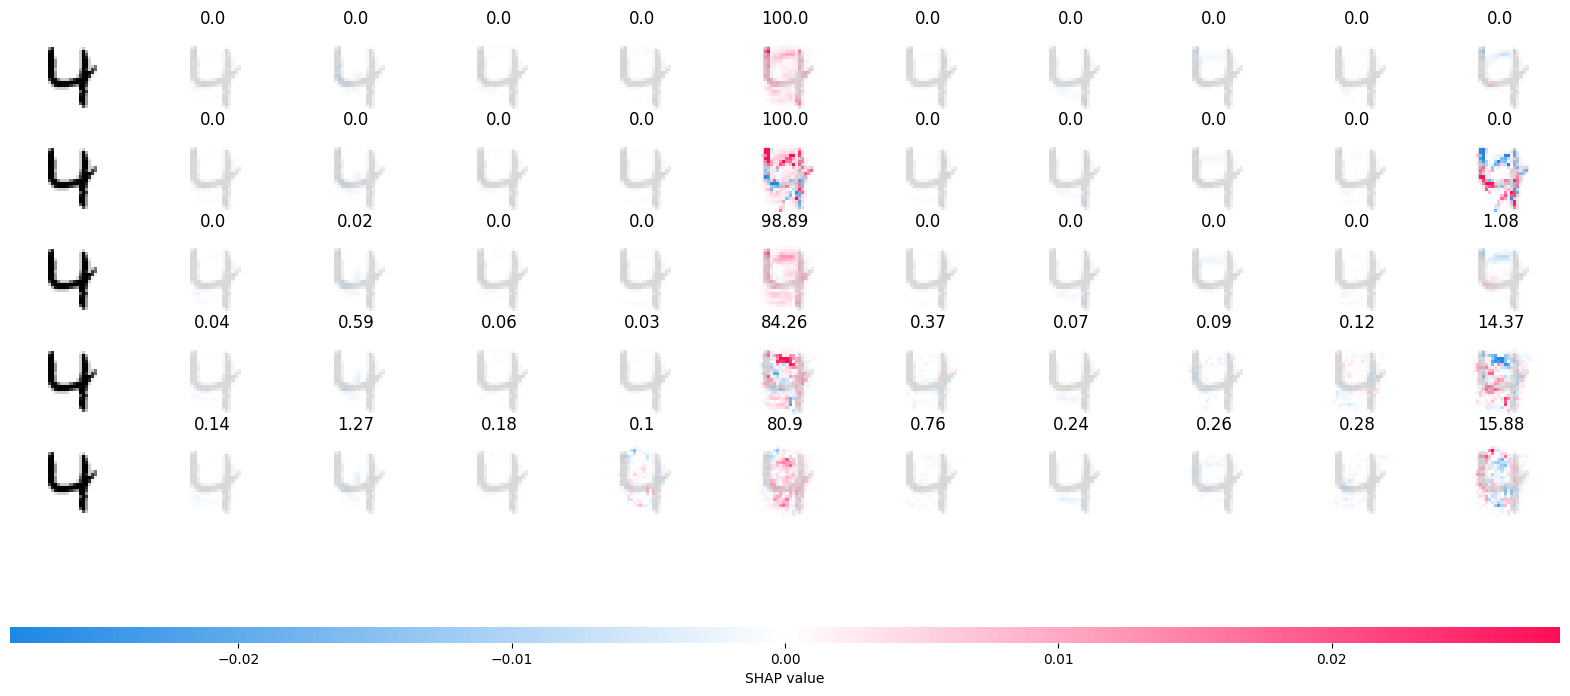

In [ ]:
plot_shap(noise_images_list, index_img_list)

##t-SNE

In [ ]:
shap_values.shape

(5, 28, 28, 1, 10)

In [ ]:
type(shap_values)

numpy.ndarray

In [ ]:
shap_values_array = np.array(shap_values)

In [ ]:
shap_values_array.shape

(5, 28, 28, 1, 10)

In [ ]:
#Convert shap_values to Dataframe
import numpy as np
import pandas as pd

# Example data (replace this with your actual data)
# data = np.random.rand(4, 224, 224, 3, 3)

# Reshape the data to have 4 rows and 224*224*3*3 columns
reshaped_data = shap_values_array.reshape(5, -1)

# Create a pandas DataFrame
df = pd.DataFrame(reshaped_data)

# Generate column names for the DataFrame (optional)
column_names = [f'pixel_{i}_{j}_{k}_{l}' for i in range(28) for j in range(28) for k in range(1) for l in range(10)]
df.columns = column_names

df

,pixel_0_0_0_0,pixel_0_0_0_1,pixel_0_0_0_2,pixel_0_0_0_3,pixel_0_0_0_4,pixel_0_0_0_5,pixel_0_0_0_6,pixel_0_0_0_7,pixel_0_0_0_8,pixel_0_0_0_9,...,pixel_27_27_0_0,pixel_27_27_0_1,pixel_27_27_0_2,pixel_27_27_0_3,pixel_27_27_0_4,pixel_27_27_0_5,pixel_27_27_0_6,pixel_27_27_0_7,pixel_27_27_0_8,pixel_27_27_0_9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_pred = cnn.predict(X_test_final)
y_pred = [np.argmax(i) for i in y_pred]
y_pred

1/1 [==============================] - 0s 30ms/step


[3, 3, 3, 3, 3]

In [ ]:
y_test[0:5]

array([7, 2, 1, 0, 4], dtype=uint8)

In [ ]:
df['y'] = y_pred
X_train = df.drop('y' , axis = 1)
Y_train = df['y']

In [ ]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import plotly.express as px

# Assuming 'df' is your DataFrame with shape (10, number of features)

perplexity = np.arange(1, min(55, df.shape[0]), 1)  # Ensure perplexity is less than n_samples
divergence = []

for i in perplexity:
    model = TSNE(n_components=2, init="pca", perplexity=i)
    reduced = model.fit_transform(df)
    divergence.append(model.kl_divergence_)

fig = px.line(x=perplexity, y=divergence, markers=True)
fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
fig.update_traces(line_color="red", line_width=1)
fig.show()

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,perplexity = 3)
X_train_tsne = tsne.fit_transform(X_train)

tsne.kl_divergence_

0.012355471961200237

In [ ]:
import plotly.express as px
fig = px.scatter(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], color=Y_train)
fig.update_layout(
    title="t-SNE visualization",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

# Divergence

In [ ]:
import pandas as pd

In [ ]:
df_0_client = pd.read_csv('/content/shap_values_0_Client.csv')
df_0_controller = pd.read_csv('/content/shap_values_0_Controller.csv')
df_1_client = pd.read_csv('/content/shap_values_1_Client.csv')
df_1_controller = pd.read_csv('/content/shap_values_1_Controller.csv')
df_2_client = pd.read_csv('/content/shap_values_2_Client.csv')
df_2_controller = pd.read_csv('/content/shap_values_2_Controller.csv')
df_3_client = pd.read_csv('/content/shap_values_3_Client.csv')
df_3_controller = pd.read_csv('/content/shap_values_3_Controller.csv')
df_4_client = pd.read_csv('/content/shap_values_4_Client.csv')
df_4_controller = pd.read_csv('/content/shap_values_4_Controller.csv')
df_5_client = pd.read_csv('/content/shap_values_5_Client.csv')
df_5_controller = pd.read_csv('/content/shap_values_5_Controller.csv')
df_6_client = pd.read_csv('/content/shap_values_6_Client.csv')
df_6_controller = pd.read_csv('/content/shap_values_6_Controller.csv')
df_7_client = pd.read_csv('/content/shap_values_7_Client.csv')
df_7_controller = pd.read_csv('/content/shap_values_7_Controller.csv')
df_8_client = pd.read_csv('/content/shap_values_8_Client.csv')
df_8_controller = pd.read_csv('/content/shap_values_8_Controller.csv')
df_9_client = pd.read_csv('/content/shap_values_9_Client.csv')
df_9_controller = pd.read_csv('/content/shap_values_9_Controller.csv')

In [ ]:
df_0_client.head(1)

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# %matplotlib inline
import collections
import math
import numpy as np
import scipy as sp
import statsmodels.api as sm

In [ ]:
from scipy.spatial import distance

In [ ]:
print(df_0_client.describe())

           0      1      2      3      4      5      6      7      8      9  \
count  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   
mean     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
std      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
min      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
25%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
50%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
75%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
max      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

       ...    774    775    776    777    778    779    780    781    782  \
count  ...  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   
mean   ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
std    ...    0.0    0.0    0.0    0.0    0.0    0.0    0

In [ ]:
df_0_controller.describe()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_0_client_0_783 = df_0_client.iloc[:, :784]
df_0_controller_0_783 = df_0_controller.iloc[:, :784]

In [ ]:
df_0_client_0_783.shape

(10, 784)

In [ ]:
df_0_client.std().nlargest(10)

,0
242,0.000823
187,0.000725
270,0.000707
244,0.000670
186,0.000645
269,0.000612
357,0.000596
215,0.000588
271,0.000586
188,0.000580


In [ ]:
df_0_controller.std().nlargest(10)

,0
425,0.012933
358,0.008326
342,0.008230
426,0.007571
454,0.007507
330,0.007162
274,0.006998
453,0.006991
598,0.006854
456,0.006845


In [ ]:
df_0_client_0_783.std().nlargest(10)

,0
690,0.000036
720,0.000035
726,0.000035
696,0.000030
700,0.000024
706,0.000020
666,0.000018
660,0.000018
730,0.000014
736,0.000014


In [ ]:
df_0_controller_0_783.std().nlargest(10)

,0
690,0.000063
696,0.000040
660,0.000034
666,0.000033
700,0.000032
726,0.000027
720,0.000027
686,0.000025
676,0.000022
706,0.000019


#### JS Divergence

In [ ]:
p = np.array(df_6_client["242"])
q = np.array(df_6_controller["242"])


In [ ]:
p

array([ 0.00404992,  0.01054016, -0.00046392,  0.00089849,  0.00710914,
       -0.00087984,  0.01119206,  0.01506754,  0.00341002,  0.00058514])

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy

# Helper function to compute JS Divergence between two distributions
def js_divergence(P, Q):
    # Convert arrays to numpy arrays (in case they're not)
    P = np.array(P)
    Q = np.array(Q)

    # Normalize to ensure they are valid probability distributions
    P = P / np.sum(P)
    Q = Q / np.sum(Q)

    # Calculate the average distribution M
    M = 0.5 * (P + Q)

    # Compute the KL divergence between P and M, and Q and M
    kl_P_M = entropy(P, M)  # KL Divergence P || M
    kl_Q_M = entropy(Q, M)  # KL Divergence Q || M

    a = np.sum(kl_P_M)
    b = np.sum(kl_Q_M)


    # JS Divergence is the average of the two KL divergences
    jsd = 0.5 * (kl_P_M + kl_Q_M)

    return np.sqrt(jsd)


# # Perform t-SNE dimensionality reduction
# tsne = TSNE(n_components=2, random_state=42)
# tsne_results = tsne.fit_transform(data)

# p = pd.DataFrame(p)
# q = pd.DataFrame(q)
# df = pd.concat([p, q], axis=1)
# df.columns = ['Client', 'Controller']


# # Compute pairwise distances in t-SNE space
# pairwise_distances = squareform(pdist(df, 'euclidean'))

# # Convert distances to probability distributions (e.g., using softmax)
# def softmax(x):
#     return np.exp(-x) / np.sum(np.exp(-x), axis=0)

# # Create probability distributions from the distances
# prob_distributions = np.apply_along_axis(softmax, 1, pairwise_distances)

# # Select two points (e.g., first two rows) and compute JS Divergence between them
# P = prob_distributions[0]  # Probability distribution for point 1
# Q = prob_distributions[1]  # Probability distribution for point 2

# Compute JS Divergence between the two probability distributions
jsd_value = js_divergence(np.abs(p), np.abs(q))

print(f"JS Divergence between two t-SNE points: {jsd_value}")


JS Divergence between two t-SNE points: 0.4295743637898599


In [ ]:
p = df_0_client.iloc[0, :]
q = df_0_controller.iloc[0, :]

In [ ]:
p = np.array(p)
q = np.array(q)
p.shape

(784,)

In [ ]:
from scipy.spatial import distance
js_dis = distance.jensenshannon(np.abs(p), np.abs(q), axis = 0)
js_dis ** 2
# js_dis

0.1845341340254629

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import math

cos_sim = cosine_similarity([p],[q])
cos_deg = math.degrees(math.acos(cos_sim))
cos_sim
cos_deg

#### KDE Plot

In [ ]:
df_7_client.std().nlargest(10)

,0
257,0.008933
231,0.007160
258,0.007159
229,0.006042
204,0.006018
232,0.005721
228,0.005631
230,0.005566
233,0.005535
202,0.005357


In [ ]:
df_7_controller.std().nlargest(10)

,0
230,0.008148
257,0.008138
229,0.007937
205,0.007393
231,0.007220
232,0.006884
287,0.006635
288,0.006484
228,0.006099
468,0.005931


In [ ]:
def find_common_values_std(df_client, df_controller, n=10):
  common_values = list(set(df_client.std().nlargest(n).keys()) & set(df_controller.std().nlargest(n).keys()))

  # Print the result
  return common_values

In [ ]:
def importance_based_on_diff_std(df_client, df_controller, n=10):
  # Perform the subtraction
  df_diff = df_controller - df_client

  # Calculate the standard deviation for each column
  std_dev = df_diff.std()

  # Find the top 10 columns with the highest standard deviation
  top_10_columns = std_dev.nlargest(n)

  return top_10_columns

In [ ]:
def importance_based_on_diff_maxval(df_client, df_controller, n=10):
  # Perform the subtraction
  df_diff = (df_controller - df_client).abs()

  # Sum the values for each column
  column_sums = df_diff.sum()

  # Identify the top 10 columns with the largest sums
  top_10_columns = column_sums.nlargest(n)

  return top_10_columns

In [ ]:
def importance_based_on_diff_sum_of_sq(df_client, df_controller, n=10):
  # Perform the subtraction
  df_diff = (df_controller - df_client).abs()

  # Sum the values for each column
  column_sums = df_diff.sum()
  column_sums_sq = column_sums ** 2

  # Identify the top 10 columns with the largest sums
  top_10_columns = column_sums_sq.nlargest(n)

  return top_10_columns

In [ ]:
import pandas as pd

# Assuming df1 and df2 are your two dataframes of shape (10, 784)

# Step 1: Calculate mean or standard deviation across the 10 images for each pixel in both dataframes
def importance_based_on_mean_absdiff(df1, df2):
  mean_df1 = df1.mean(axis=0)
  mean_df2 = df2.mean(axis=0)

  # Step 2: Compute absolute difference between means
  mean_difference = abs(mean_df1 - mean_df2)

  # Step 3: Sort columns by the highest differences
  most_contributive_columns = mean_difference.sort_values(ascending=False)

  # Display the top N contributive columns
  top_n = 10  # choose the top N most contributive columns
  return most_contributive_columns.head(top_n)


In [ ]:
np.arange(784)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
import numpy as np
def importance_based_on_heatmap(df_controller, num_pixels = 300):
    keys = np.arange(784)
    for i in range(100):
        shap_list = df_controller.iloc[i, :]
        # shap_heatmap = np.abs(shap_list)

        #   # Normalize SHAP heatmap between 0 and 1
        # shap_heatmap = shap_heatmap / np.max(shap_heatmap)

        important_pixels = np.argsort(np.abs(shap_list.ravel()))[-num_pixels:]
        keys = np.intersect1d(keys, important_pixels)

    return keys

In [ ]:
l = importance_based_on_heatmap(df_0_controller)
l

<ipython-input-28-450e6fcd4c1a>:11: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  important_pixels = np.argsort(np.abs(shap_list.ravel()))[-num_pixels:]


array([182, 183, 238, 239, 270, 297, 298, 299, 300, 325, 326, 327, 344,
       348, 349, 350, 351, 352, 353, 354, 355, 375, 376, 377, 378, 379,
       380, 381, 382, 383, 402, 403, 404, 405, 406, 407, 408, 409, 410,
       428, 430, 431, 432, 433, 434, 435, 436, 437, 455, 456, 458, 459,
       460, 461, 462, 463, 464, 465, 466, 468, 487, 488, 489, 490, 492,
       493, 520, 576, 602])

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif , mutual_info_classif
import numpy as np
def Select_Best_k(X , target):
    y = [target]*100
    feature_names  = np.arange(784)
    selector = SelectKBest(score_func=mutual_info_classif, k=10)
    X_new = selector.fit_transform(X, y)
    selected_features = selector.get_support()  # Boolean mask
    selected_feature_names = [feature_names[i] for i in range(len(feature_names)) if selected_features[i]]
    return selected_feature_names

In [ ]:
!pip install kneed

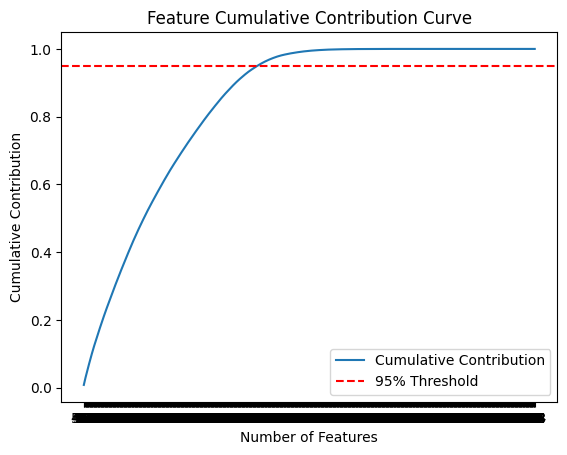

Optimal Threshold: 1.00


<ipython-input-79-dcb2ff59750c>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  optimal_threshold = cumulative_contribution[knee.knee]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `cumulative_contribution` is computed as before
# Plot cumulative contribution
plt.plot(cumulative_contribution, label="Cumulative Contribution")
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Contribution")
plt.title("Feature Cumulative Contribution Curve")
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Threshold')
plt.legend()
plt.show()

# Automatically detect the elbow point
from kneed import KneeLocator

knee = KneeLocator(range(len(cumulative_contribution)), cumulative_contribution, curve="convex", direction="increasing")
optimal_threshold = cumulative_contribution[knee.knee]
print(f"Optimal Threshold: {optimal_threshold:.2f}")


In [ ]:
import numpy as np
import pandas as pd
import shap


def Importance_based_on_Cummulative_Sum(df):
  # Assuming:
  # - `shap_values` is a 2D array of SHAP values (shape: [num_samples, num_features])
  # - `feature_names` is a list of feature names
  shap_values = df
  # Step 1: Compute Mean Absolute SHAP Values
  mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)

  # Step 2: Sort Features by Importance
  sorted_indices = np.argsort(mean_abs_shap_values)[::-1]  # Indices of features sorted by importance
  sorted_shap_values = mean_abs_shap_values[sorted_indices]


  feature_names = np.arange(784)
  sorted_feature_names = [feature_names[i] for i in sorted_indices]

  # Step 3: Compute Cumulative Contribution
  cumulative_contribution = np.cumsum(sorted_shap_values) / np.sum(sorted_shap_values)

  # Step 4: Select Top-k Features Based on Threshold
  threshold = 0.65  # Set the desired threshold (e.g., 95%)
  top_k = np.argmax(cumulative_contribution >= threshold) + 1  # Find minimum k meeting the threshold

  # Extract the selected features
  selected_features = sorted_feature_names[:top_k]

  # Display results
  # print(f"Top-{top_k} Features (95% Contribution): {selected_features}")

  # Optional: Create a DataFrame for visualization
  feature_importance_df = pd.DataFrame({
      'Feature': sorted_feature_names,
      'Mean SHAP Value': sorted_shap_values,
      'Cumulative Contribution': cumulative_contribution
  })

  # print(feature_importance_df.head(top_k))
  return selected_features


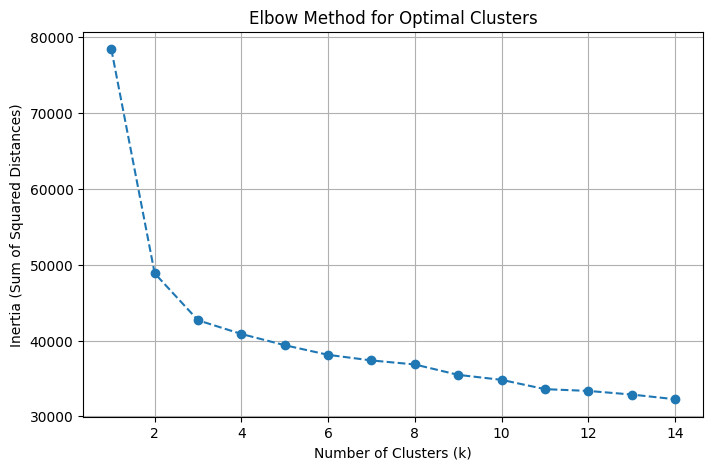

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Step 1: Define the range of cluster numbers to test
cluster_range = range(1, 15)
shap_values = df_4_controller
feature_names = np.arange(784)
# Step 1: Compute Mean SHAP Values for Each Feature
mean_shap_values = np.mean(np.abs(shap_values), axis=0)

# Step 2: Standardize SHAP Values Across Samples
scaler = StandardScaler()
shap_values_scaled = scaler.fit_transform(shap_values.T)  # Transpose for clustering features
# Step 2: Calculate Inertia for Each Cluster Count
inertia_values = []
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(shap_values_scaled)  # SHAP values scaled from previous steps
    inertia_values.append(kmeans.inertia_)

# Step 3: Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal Clusters')
plt.grid()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import shap

# Assuming `shap_values` is a 2D array of SHAP values (samples x features)
# and `feature_names` is a list of corresponding feature names
def Importance_based_on_clustering(df):
        shap_values = df
        feature_names = np.arange(784)
        # Step 1: Compute Mean SHAP Values for Each Feature
        mean_shap_values = np.mean(np.abs(shap_values), axis=0)

        # Step 2: Standardize SHAP Values Across Samples
        scaler = StandardScaler()
        shap_values_scaled = scaler.fit_transform(shap_values.T)  # Transpose for clustering features

        # Step 3: Apply Clustering (e.|g., k-means)
        num_clusters = 5  # Define the number of clusters
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(shap_values_scaled)

        # Step 4: Select Representative Feature from Each Cluster
        selected_features = []
        for cluster in range(num_clusters):
            # Get indices of features in the current cluster
            cluster_indices = np.where(cluster_labels == cluster)[0]

            # Find the feature with the highest mean SHAP value in the cluster
            representative_index = cluster_indices[np.argmax(mean_shap_values[cluster_indices])]
            selected_features.append(feature_names[representative_index])

        # Print Selected Features
        # print(f"Selected Features from {num_clusters} Clusters: {selected_features}")

        # Optional: Create a DataFrame for Visualization
        feature_cluster_df = pd.DataFrame({
            'Feature': feature_names,
            'Cluster': cluster_labels,
            'Mean SHAP Value': mean_shap_values
        })
        # print(feature_cluster_df.sort_values('Cluster'))
        return selected_features


In [ ]:

def importance_based_on_graph(df_controller, method='mst'):
  import numpy as np

  # Compute correlation matrix (absolute values to focus on similarity strength)
  correlation_matrix = np.corrcoef(df_controller.T)
  np.fill_diagonal(correlation_matrix, 0)  # Remove self-loops

  import networkx as nx

  # Create graph from correlation matrix
  G = nx.Graph()
  num_features = df_controller.shape[1]

  for i in range(num_features):
      for j in range(i + 1, num_features):
          weight = correlation_matrix[i, j]
          if weight > 0.5:  # Threshold to determine significant similarity
              G.add_edge(i, j, weight=weight)

  if method == 'mst':
      # Compute minimum spanning tree
      mst = nx.minimum_spanning_tree(G, weight='weight')
      # mst_edges = list(mst.edges(data=True))
      selected_features = list(mst.nodes)
  elif method == 'pagerank':
      # Compute PageRank scores
      pagerank_scores = nx.pagerank(G)
      selected_features = sorted(pagerank_scores, key=pagerank_scores.get, reverse=True)
  elif method == 'degree':
      # Compute degree centrality
      degree_centrality = nx.degree_centrality(G)
      selected_features = sorted(degree_centrality, key=degree_centrality.get, reverse=True)
  elif method == 'eigenvector':
      # Compute eigenvector centrality
      eigenvector_centrality = nx.eigenvector_centrality(G)
      selected_features = sorted(eigenvector_centrality, key=eigenvector_centrality.get, reverse=True)
  elif method == 'betweenness':
      # Compute betweenness centrality
      betweenness_centrality = nx.betweenness_centrality(G)
      selected_features = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)
  elif method == 'closeness':
      # Compute closeness centrality
      closeness_centrality = nx.closeness_centrality(G)
      selected_features = sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)

  else:
      raise ValueError("Invalid method. Choose from 'mst', 'pagerank', 'degree', 'eigenvector', 'betweeness' or 'closeness'.")

  return selected_features


In [ ]:
import numpy as np
import pandas as pd
import shap
from sklearn.feature_selection import SelectKBest, f_classif

def Importance_based_on_Cummulative_Sum_Improved(df, y):
    """
    Calculates feature importance based on cumulative sum of SHAP values,
    incorporating feature correlation and k-best feature selection.

    Args:
        df: 2D array of SHAP values (shape: [num_samples, num_features])
        y: Labels for the data

    Returns:
        List of indices of the selected features
    """

    # Step 1: Compute Mean Absolute SHAP Values
    mean_abs_shap_values = np.mean(np.abs(df), axis=0)

    # Step 2: Sort Features by Importance
    sorted_indices = np.argsort(mean_abs_shap_values)[::-1]
    sorted_shap_values = mean_abs_shap_values[sorted_indices]

    # Step 3: Compute Cumulative Contribution
    cumulative_contribution = np.cumsum(sorted_shap_values) / np.sum(sorted_shap_values)

    # Step 4: Select Top-k Features Based on Threshold
    threshold = 0.5 # Set the desired threshold (e.g., 95%)
    top_k = np.argmax(cumulative_contribution >= threshold) + 1

    # Step 5: Calculate feature correlations
    correlation_matrix = np.corrcoef(df.T)
    selected_features_corr_filtered = []
    for feature in sorted_indices[:top_k]:
          if all(
              abs(correlation_matrix[feature, other_feature]) < threshold
              for other_feature in selected_features_corr_filtered
          ):
              selected_features_corr_filtered.append(feature)

    # Step 6: Select features using SelectKBest (e.g., with f_classif)
    k_best = SelectKBest(f_classif, k=int(0.5 * df.shape[1]))  # Select half of the features
    X_new = k_best.fit_transform(df, y)
    selected_features_kbest = k_best.get_support(indices=True)

    # Step 7: Combine SHAP-based selection with k-best features
    # selected_features = list(set(sorted_indices[:top_k]) & set(selected_features_kbest))
    selected_features = list(set(selected_features_corr_filtered) & set(selected_features_kbest))


    return selected_features



In [ ]:
import numpy as np
import pandas as pd
import shap
from sklearn.feature_selection import SelectKBest, f_classif

def Importance_based_on_Cummulative_Sum_Improved(df, y):
    """
    Calculates feature importance based on cumulative sum of SHAP values,
    incorporating feature correlation and k-best feature selection.

    Args:
        df: 2D array of SHAP values (shape: [num_samples, num_features])
        y: Labels for the data

    Returns:
        List of indices of the selected features
    """

    # Step 1: Compute Mean Absolute SHAP Values
    mean_abs_shap_values = np.mean(np.abs(df), axis=0)

    # Step 2: Sort Features by Importance
    sorted_indices = np.argsort(mean_abs_shap_values)[::-1]
    sorted_shap_values = mean_abs_shap_values[sorted_indices]

    # Step 3: Compute Cumulative Contribution
    cumulative_contribution = np.cumsum(sorted_shap_values) / np.sum(sorted_shap_values)

    # Step 4: Select Top-k Features Based on Threshold
    threshold = 0.95  # Set the desired threshold (e.g., 95%)
    top_k = np.argmax(cumulative_contribution >= threshold) + 1

    # Step 5: Calculate feature correlations
    correlation_matrix = np.corrcoef(df.T)

    # Step 6: Select features using SelectKBest (e.g., with f_classif)
    k_best = SelectKBest(f_classif, k=int(0.5 * df.shape[1]))  # Select half of the features
    X_new = k_best.fit_transform(df, y)
    selected_features_kbest = k_best.get_support(indices=True)

    # Step 7: Combine SHAP-based selection with k-best features
    selected_features = list(set(sorted_indices[:top_k]) & set(selected_features_kbest))

    return selected_features

In [ ]:
Select_Best_k(df_0_controller , 0)

[774, 775, 776, 777, 778, 779, 780, 781, 782, 783]

In [ ]:
find_common_values_std(df_6_client, df_6_controller, n=20)


['438', '410']

In [ ]:
keys = importance_based_on_diff_std(df_6_client, df_6_controller, n=10).keys().values
keys

array(['438', '514', '485', '513', '486', '543', '439', '570', '383',
       '410'], dtype=object)

In [ ]:
importance_based_on_diff_maxval(df_6_client, df_6_controller)

,0
242,0.762658
485,0.734864
514,0.704522
214,0.675627
270,0.673039
213,0.670364
457,0.654308
486,0.652331
513,0.644174
241,0.632196


## Quartile Division

### Using quartile

In [ ]:

def df_column(df_client , df_controller , y):
    a1 = find_common_values_std(df_client, df_controller, n=20)
    a2 = importance_based_on_diff_std(df_client, df_controller, n=10).keys().values
    a3 = importance_based_on_diff_maxval(df_client, df_controller).keys().values
    a4 = importance_based_on_diff_sum_of_sq(df_client, df_controller).keys().values
    a5 = importance_based_on_mean_absdiff(df_client, df_controller).keys().values
    a6 = importance_based_on_heatmap(df_controller)
    a7 = Importance_based_on_Cummulative_Sum(df_controller)
    a8 = Importance_based_on_clustering(df_controller)
    a9 = importance_based_on_graph(df_controller, method='mst')
    a10 = importance_based_on_graph(df_controller, method='pagerank')
    a11 = importance_based_on_graph(df_controller, method='degree')
    a12 = importance_based_on_graph(df_controller, method='eigenvector')
    a13 = importance_based_on_graph(df_controller, method='betweenness')
    a14 = Importance_based_on_Cummulative_Sum_Improved(df_controller, y)
    a15 = importance_based_on_graph(df_controller, method='closeness')
    print("Cummulative_Sum_Improved:\t", a14)
    return a1 , a2 , a3 , a4 , a5 , a6 , a7 , a8, a9, a10, a11, a12, a13 , a14 , a15



In [ ]:
k1 , k2 , k3 , k4 , k5, k6 , k7 , k8 , k9 , k10 , k11 , k12 , k13 , k14 , k15= df_column(df_6_client, df_6_controller , 6)

<ipython-input-9-450e6fcd4c1a>:11: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  important_pixels = np.argsort(np.abs(shap_list.ravel()))[-num_pixels:]
<ipython-input-11-023e5e522ce0>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_shap_values = mean_abs_shap_values[sorted_indices]
<ipython-input-15-a1b309d1dd2e>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  representative_index = cluster_indices[np.argmax(mean_shap_values[cluster_indices])]
/usr/local/lib/python3.10/dist-packages/nump

TypeError: Input should have at least 1 dimension i.e. satisfy `len(x.shape) > 0`, got scalar `array(6)` instead.

In [ ]:
import pandas as pd
import numpy as np
# from scipy.spatial import distance
from scipy.stats import entropy
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity


# Function to calculate quartiles and split data into quartiles
def split_into_quartiles(df, column):
    q1 = df[column].quantile(0.25)
    q2 = df[column].quantile(0.50)
    q3 = df[column].quantile(0.75)

    quartile_1 = df[df[column] <= q1]
    quartile_2 = df[(df[column] > q1) & (df[column] <= q2)]
    quartile_3 = df[(df[column] > q2) & (df[column] <= q3)]
    quartile_4 = df[df[column] > q3]

    return [quartile_1[column], quartile_2[column], quartile_3[column], quartile_4[column]]

# Function to calculate a probability distribution from a quartile
def get_distribution(data):
    count = Counter(data)
    total = sum(count.values())
    distribution = {k: v / total for k, v in count.items()}
    return distribution

# Function to calculate Jensen-Shannon Divergence between two distributions
def js_divergence(P, Q):
    P = np.array(list(P.values()))
    Q = np.array(list(Q.values()))
    # If distributions are not the same length, pad with zeroes
    length = max(len(P), len(Q))
    P = np.pad(P, (0, length - len(P)))
    Q = np.pad(Q, (0, length - len(Q)))

    M = 0.5 * (P + Q)
    js_score = 0.5 * entropy(P, M) + 0.5 * entropy(Q, M)
    return js_score

def calculate_js_quartile(df1, df2, column):
    # Split each DataFrame into quartiles
    quartiles_df1 = split_into_quartiles(df1, column)
    quartiles_df2 = split_into_quartiles(df2, column)

    # Calculate JS Divergence for corresponding quartiles of the two DataFrames
    js_divergence_scores = []
    cosine_similarity_scores = []

    for i in range(4):
        dist_df1 = get_distribution(quartiles_df1[i])
        dist_df2 = get_distribution(quartiles_df2[i])

        js_score = js_divergence(dist_df1, dist_df2)
        js_divergence_scores.append(js_score)
        # print(f"Jensen-Shannon Divergence for Quartile {i+1}: {js_score}")

        p = np.array(quartiles_df1[i])
        q = np.array(quartiles_df2[i])
        cosine_similarity_scores.append(cosine_similarity([p],[q]))

    # Display the results
    print("Jensen-Shannon Divergence Scores for each quartile comparison:")
    print(js_divergence_scores)
    print("Cosine Similarity Scores for each quartile comparison:")
    print(cosine_similarity_scores)


In [ ]:
calculate_js_quartile(df_6_client, df_6_controller, '410')

Jensen-Shannon Divergence Scores for each quartile comparison:
[0.0, 0.0, 0.0, 0.0]
Cosine Similarity Scores for each quartile comparison:
[array([[-0.4822694]]), array([[-0.9262144]]), array([[-0.95693735]]), array([[-0.11318732]])]


### Using Histogram

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
from sklearn.metrics.pairwise import cosine_similarity
import math

# Assuming benign_df and poisoned_df are your two DataFrames
# Both DataFrames should have the same structure (same columns and rows)

# Function to compute JS divergence for corresponding quartiles of two data arrays
def compute_js_divergence(arr1, arr2):
    arr1_probs, _ = np.histogram(arr1, bins=4, density=True)
    arr2_probs, _ = np.histogram(arr2, bins=4, density=True)
    js_dis = jensenshannon(arr1_probs, arr2_probs, base=2)  # JS Distance
    return js_dis  # Jensen-Shannon Distance is the square root of JS Divergence

def calculate_js_hist_quartile(benign_df, poisoned_df, column):
  # Get quartiles for benign and poisoned DataFrames
    benign_quartiles = pd.qcut(benign_df[column], q=4, labels=False)
    poisoned_quartiles = pd.qcut(poisoned_df[column], q=4, labels=False)
    # Initialize list to store JS scores for each quartile
    js_scores = []
    cosine_similarity_scores = []
    cosine_degree = []
    # Iterate over each quartile
    for q in range(4):
        # Select data for the current quartile
        benign_data = benign_df[column][benign_quartiles == q]
        poisoned_data = poisoned_df[column][poisoned_quartiles == q]
        # Compute JS divergence between the two distributions
        js_div = compute_js_divergence(benign_data, poisoned_data)
        js_scores.append(js_div)

        # p = np.array(benign_data)
        # q = np.array(poisoned_data)
        # cosine_similarity_scores.append(cosine_similarity([p],[q]))
        # cosine_degree.append(math.degrees(math.acos(cosine_similarity([p],[q]))))


    # Store the JS divergence scores for each quartile of this column

    # print(js_scores)
    # print(cosine_similarity_scores)
    # print(cosine_degree)
    # print("Sum of JS divergence:", sum(js_scores))

    return np.sum(js_scores)


In [ ]:
js_list = []
for i in range(0, 784):
    try:
      js_list.append(calculate_js_hist_quartile(df_3_client, df_3_controller, str(i)))
      print(i)
    except:
      js_list.append(0)
      print(i, "No")
      # break

max_scores = max(js_list)
max_index = js_list.index(max_scores)
min_scores = min(js_list)
min_index = js_list.index(min_scores)


print(max_scores)
print(max_index)
print(min_scores)
print(min_index)


# calculate_js_hist_quartile(df_6_client, df_6_controller, '484')

0 No
1 No
2 No
3 No
4 No
5 No
6 No
7 No
8 No
9 No
10 No
11 No
12 No
13 No
14 No
15 No
16 No
17 No
18 No
19 No
20 No
21 No
22 No
23 No
24 No
25 No
26 No
27 No
28 No
29 No
30 No
31 No
32 No
33 No
34 No
35 No
36 No
37 No
38 No
39 No
40
41
42
43
44 No
45 No
46 No
47 No
48 No
49 No
50 No
51 No
52 No
53 No
54 No
55 No
56 No
57 No
58 No
59 No
60 No
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80 No
81 No
82 No
83 No
84 No
85 No
86 No
87 No
88 No
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110 No
111 No
112 No
113 No
114 No
115 No
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138 No
139 No
140 No
141 No
142 No
143 No
144
145


/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:1271: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166 No
167 No
168 No
169 No
170
171
172


/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:1271: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:1271: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194 No
195 No
196 No
197 No
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222 No
223 No
224 No
225 No
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250 No
251 No
252 No
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:1271: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


277
278 No
279 No
280 No
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302


/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:1271: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


303
304
305
306 No
307 No
308 No
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334 No
335 No
336 No
337 No
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362 No
363 No
364 No
365 No
366 No
367
368
369
370
371
372
373
374


/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:1271: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390 No
391 No
392 No
393 No
394 No
395
396
397
398
399
400
401
402
403


/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:1271: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


404
405
406
407
408
409
410
411
412
413
414
415
416
417
418 No
419 No
420 No
421 No
422 No
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446 No
447 No
448 No
449 No
450 No
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474 No
475 No
476 No
477 No
478 No
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502 No
503 No
504 No
505
506
507
508
509
510
511

/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:1271: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)



512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530 No
531 No
532 No
533 No
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558 No
559 No
560 No
561 No
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586 No
587 No
588 No
589 No
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614 No
615 No
616 No
617 No
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640


/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:1271: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


641
642 No
643 No
644 No
645 No
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670 No
671 No
672 No
673 No
674 No
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696


/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:1271: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:1271: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


697 No
698 No
699 No
700 No
701 No
702 No
703 No
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723 No
724 No
725 No
726 No
727 No
728 No
729 No
730 No
731 No
732 No
733 No
734 No
735 No
736 No
737 No
738 No
739 No
740 No
741 No
742 No
743 No
744 No
745 No
746 No
747 No
748 No
749 No
750 No
751 No
752 No
753 No
754 No
755 No
756 No
757 No
758 No
759 No
760 No
761 No
762 No
763 No
764 No
765 No
766 No
767 No
768 No
769 No
770 No
771 No
772 No
773 No
774 No
775 No
776 No
777 No
778 No
779 No
780 No
781 No
782 No
783 No
1.7167660335582573
557
0
0


In [ ]:
k1 , k2 , k3 , k4 , k5 , k6 , k7 , k8 = df_column(df_2_client, df_2_controller)

Top-243 Features (95% Contribution): [348, 378, 516, 580, 488, 515, 485, 460, 154, 373, 579, 319, 401, 606, 211, 550, 578, 429, 350, 487, 519, 575, 153, 345, 457, 486, 543, 459, 180, 156, 239, 406, 376, 152, 235, 206, 512, 607, 317, 581, 155, 234, 513, 458, 634, 552, 430, 514, 179, 461, 320, 491, 551, 484, 549, 541, 402, 626, 403, 404, 431, 291, 346, 542, 375, 214, 605, 405, 604, 374, 178, 290, 432, 574, 520, 347, 289, 571, 576, 608, 577, 377, 524, 521, 207, 157, 126, 349, 489, 456, 125, 522, 548, 428, 263, 318, 572, 182, 186, 242, 523, 400, 151, 181, 599, 569, 372, 433, 184, 213, 539, 185, 236, 240, 603, 540, 600, 270, 602, 544, 573, 625, 238, 490, 212, 545, 511, 233, 124, 237, 261, 183, 379, 215, 344, 322, 570, 158, 298, 546, 241, 127, 232, 262, 601, 464, 630, 210, 209, 434, 205, 410, 323, 149, 294, 627, 518, 187, 269, 216, 271, 496, 553, 494, 382, 463, 483, 598, 629, 326, 438, 407, 371, 462, 597, 466, 493, 208, 492, 662, 128, 288, 427, 204, 150, 628, 632, 268, 547, 354, 495, 316, 40

<ipython-input-146-450e6fcd4c1a>:11: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  important_pixels = np.argsort(np.abs(shap_list.ravel()))[-num_pixels:]
<ipython-input-282-d3775c62aab9>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_shap_values = mean_abs_shap_values[sorted_indices]
<ipython-input-197-c07b12fd7427>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  representative_index = cluster_indices[np.argmax(mean_shap_values[cluster_indices])]


In [ ]:

def calculate_js_avg(df_client, df_controller , target):
  import numpy as np
  from scipy.spatial import distance
  y = [target]*100
  k1 , k2 , k3 , k4 , k5 , k6 , k7 , k8, k9, k10, k11, k12, k13 , k14 , k15= df_column(df_client, df_controller , y)
  js_list = []
  for i in k14:
    p = df_client.iloc[:, int(i)]
    q = df_controller.iloc[:, int(i)]
    js_list.append(distance.jensenshannon(np.abs(p), np.abs(q), axis = 0))

  import math
  c = 0
  sum = 0
  for i in range(len(js_list)):
      if not math.isnan(js_list[i]):
          sum += js_list[i]
          c += 1

  print(sum/c)


In [ ]:
calculate_js_avg(df_6_client, df_6_controller , 6)

<ipython-input-9-450e6fcd4c1a>:11: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  important_pixels = np.argsort(np.abs(shap_list.ravel()))[-num_pixels:]
<ipython-input-11-023e5e522ce0>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_shap_values = mean_abs_shap_values[sorted_indices]
<ipython-input-15-a1b309d1dd2e>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  representative_index = cluster_indices[np.argmax(mean_shap_values[cluster_indices])]
/usr/local/lib/python3.10/dist-packages/nump

Cummulative_Sum_Improved:	 [512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 653, 654, 655, 656, 657, 658, 659, 660, 661, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 511]
0.3619886691744978


In [ ]:
y = [0]*100
k1 , k2 , k3 , k4 , k5 , k6 , k7 , k8, k9, k10, k11, k12, k13 , k14 , k15= df_column(df_0_client, df_0_controller , y)

<ipython-input-9-450e6fcd4c1a>:11: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  important_pixels = np.argsort(np.abs(shap_list.ravel()))[-num_pixels:]
<ipython-input-11-023e5e522ce0>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_shap_values = mean_abs_shap_values[sorted_indices]
<ipython-input-15-a1b309d1dd2e>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  representative_index = cluster_indices[np.argmax(mean_shap_values[cluster_indices])]
/usr/local/lib/python3.10/dist-packages/nump

Cummulative_Sum_Improved:	 [512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 653, 654, 655, 656, 657, 658, 659, 660, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 509, 510, 511]


In [ ]:
df_0_client[[str(i) for i in k10]]

,172,668,109,200,173,721,435,119,618,284,...,193,396,550,553,146,297,523,78,494,648
0,1.824803e-08,1.986105e-10,-1.469720e-06,5.743981e-08,-0.000012,-3.438789e-10,-0.001019,-0.000008,1.751891e-10,7.994801e-07,...,-3.305032e-08,-6.802734e-07,1.809305e-05,-0.000071,-0.000016,-0.000449,-0.000078,-0.000004,-0.000321,5.056182e-09
1,4.684655e-09,-4.533108e-11,-5.366539e-07,8.591525e-09,-0.000004,-6.745079e-12,-0.000458,-0.000004,5.414911e-13,-1.060968e-06,...,-3.057455e-09,-3.087812e-08,-4.394813e-05,-0.000043,-0.000009,-0.000030,-0.000073,-0.000003,-0.000227,-1.007207e-09
2,-1.112958e-10,-4.411422e-11,-7.360881e-07,-1.878494e-10,-0.000007,-5.672038e-12,-0.000400,-0.000001,5.462453e-13,2.970520e-07,...,-7.313849e-09,-2.745860e-08,1.624927e-05,-0.000052,-0.000008,-0.000077,-0.000105,-0.000003,-0.000242,-8.213278e-11
3,1.616145e-09,2.625142e-10,-6.830016e-07,5.268248e-09,-0.000013,-4.481353e-11,-0.000579,-0.000016,2.468726e-11,8.017842e-08,...,1.639641e-08,2.767896e-06,7.440655e-05,-0.000051,-0.000017,-0.000170,0.000048,-0.000004,-0.000188,3.559983e-10
4,-1.068536e-09,-2.387945e-11,-6.849064e-07,-1.651151e-09,-0.000002,-6.086714e-13,-0.000699,-0.000005,3.663178e-12,1.861717e-07,...,-2.131116e-09,-1.259424e-08,5.053394e-07,-0.000040,-0.000008,-0.000788,-0.000249,-0.000003,-0.000038,-2.208245e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.391800e-09,9.136103e-10,-5.536344e-07,3.514389e-09,-0.000003,-2.343852e-12,-0.001091,-0.000012,1.080164e-12,2.019628e-06,...,3.958870e-09,9.354628e-08,-1.041944e-04,-0.000049,-0.000013,-0.001308,-0.000363,-0.000004,-0.000269,2.824266e-10
96,-8.398625e-10,-4.227702e-13,-6.142693e-07,-1.304559e-09,-0.000004,-1.441476e-12,-0.000829,-0.000008,2.798690e-13,1.335788e-06,...,-3.431787e-09,6.754694e-08,-1.211399e-04,-0.000070,-0.000013,-0.000058,-0.000246,-0.000003,-0.000390,7.820310e-11
97,-4.837253e-05,-2.107438e-06,-2.883408e-06,-2.611752e-05,-0.000049,-7.080491e-07,0.007851,-0.000031,-3.040153e-07,-4.020486e-05,...,2.841913e-06,3.012677e-03,-4.714989e-03,-0.000130,-0.000043,-0.006291,-0.007604,0.000028,0.001204,1.052008e-06
98,-3.142057e-10,2.968285e-13,-6.278732e-07,-5.870737e-10,-0.000004,-3.457109e-12,-0.000869,-0.000011,2.149655e-13,1.798838e-06,...,-8.661956e-09,1.264681e-07,-1.446079e-05,-0.000053,-0.000013,-0.000051,-0.000069,-0.000003,-0.000418,-5.331924e-13


In [ ]:
j = calculate_js_hist_quartile(df_6_client, df_6_controller,"242" )
j

0.1388120807532226

In [ ]:
p = np.array(df_5_client["595"])
q = np.array(df_5_controller["595"])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import math

cos_sim = cosine_similarity([p],[q])
cos_deg = math.degrees(math.acos(cos_sim))
print(cos_sim)
print(cos_deg)


[[0.09500247]]
84.54853788013445


<ipython-input-91-593892fca8ac>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cos_deg = math.degrees(math.acos(cos_sim))


In [ ]:
from scipy.spatial.distance import jensenshannon
js_div = jensenshannon(np.abs(p), np.abs(q), axis = 0)
js_div ** 2


0.0028870552807558044

In [ ]:
p = np.array(df_6_client["410"])
q = np.array(df_6_controller["410"])


In [ ]:
import numpy as np
p = np.array(df_9_client.sum(axis=0))
q = np.array(df_9_controller.sum(axis=0))
p.shape

(784,)

In [ ]:
from scipy.spatial import distance
js_dis = distance.jensenshannon(np.abs(p), np.abs(q), axis = 0)
js_dis

0.10721984847572788

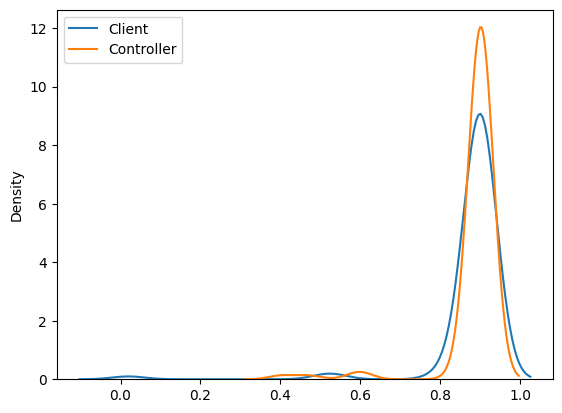

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(p,label='Client')
sns.kdeplot(q,label='Controller')
plt.legend()
plt.show()

In [ ]:
# prompt: Get the columns from the df_0_controller according to the column names in k15

import pandas as pd

# Assuming df_0_controller and k15 are defined in your environment

# Convert k15 to a list if it's not already
if not isinstance(k15, list):
    k15 = list(k15)

# Extract columns from df_0_controller based on column names in k15
selected_columns = []
for col_name in k15:
    if str(col_name) in df_0_controller.columns:
        selected_columns.append(df_0_controller[str(col_name)])
    else:
        print(f"Warning: Column '{col_name}' not found in df_0_controller")

# Create a new DataFrame with selected columns (if any were found)
if selected_columns:
    selected_df = pd.concat(selected_columns, axis=1)
    selected_df
else:
    print("No matching columns found in df_0_controller.")

In [ ]:
def get_dataframe(df, k):
  # Convert k to a list if it's not already
  if not isinstance(k, list):
    k = list(k)

  # Extract columns from df based on column names in k
  selected_columns = []
  for col_name in k:
    if str(col_name) in df.columns:
      selected_columns.append(df[str(col_name)])
    else:
      print(f"Warning: Column '{col_name}' not found in df_0_controller")

  # Create a new DataFrame with selected columns (if any were found)
  if selected_columns:
    selected_df = pd.concat(selected_columns, axis=1)
    return selected_df
  else:
    return ValueError("No matching columns found in df_0_controller.")

In [ ]:
get_dataframe(df_0_controller, k15)

,200,256,379,562,255,172,173,109,282,310,...,116,144,124,125,181,182,492,722,684,685
0,0.000057,0.000069,0.002399,1.571574e-06,0.000028,0.000043,0.000124,1.901899e-06,0.000005,1.605315e-06,...,-9.200843e-09,-1.871166e-06,0.000457,-0.000073,0.002624,0.002296,0.001365,-2.674249e-07,0.001385,0.001261
1,0.000056,0.000060,0.001468,1.741292e-06,0.000021,0.000039,0.000107,4.129279e-07,0.000004,1.156466e-07,...,-1.155301e-08,-1.577202e-06,0.000675,0.000417,0.002414,0.002196,0.003612,1.586700e-08,0.000565,0.000587
2,0.000052,0.000071,0.001731,1.689383e-06,0.000027,0.000040,0.000113,1.147478e-06,0.000004,1.070758e-06,...,-1.358087e-08,-1.783201e-06,0.000561,0.000794,0.001601,0.002534,0.002140,-1.278263e-07,0.000230,0.001720
3,0.000054,0.000103,0.002277,9.986250e-07,0.000042,0.000037,0.000092,3.234668e-07,0.000006,1.065974e-06,...,-2.105277e-08,-1.831908e-06,0.000347,0.000516,0.000691,0.001881,0.001599,-1.891981e-07,0.000916,0.001035
4,0.000065,0.000079,0.003298,1.512265e-06,0.000030,0.000049,0.000104,9.526285e-07,0.000007,1.702613e-06,...,2.148355e-08,3.441181e-07,0.000291,0.000318,0.000508,0.001746,0.002788,-9.372094e-08,0.000961,0.000099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000072,0.000092,0.005961,3.128689e-06,0.000046,0.000051,0.000127,7.454275e-07,0.000009,2.111222e-06,...,-2.428039e-08,-2.291094e-06,0.000740,0.000714,0.003031,0.003066,0.002059,-1.033059e-07,0.000026,0.000720
96,0.000055,0.000061,0.001710,1.169896e-06,0.000024,0.000046,0.000120,8.127913e-07,0.000007,1.714546e-06,...,-3.001482e-09,-6.092123e-07,0.000482,0.000592,0.001571,0.001467,0.002108,-7.924037e-09,0.000220,0.000813
97,0.000074,0.000143,0.002351,2.947213e-06,0.000068,0.000051,0.000097,2.372511e-06,0.000008,1.084492e-06,...,1.604678e-08,-8.404481e-07,0.001311,0.001402,0.002308,0.002295,0.001484,-4.162435e-07,0.000648,0.000530
98,0.000052,0.000055,0.002187,1.234336e-06,0.000023,0.000046,0.000118,6.952419e-07,0.000007,1.779853e-06,...,-2.467991e-09,-5.196401e-07,0.000608,0.000655,0.002344,0.002786,0.002894,-3.251247e-09,0.000363,0.000048


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def kde_plot(df_controller, df_client, target):
  print(df_controller.shape[0])
  y = [target]*df_controller.shape[0]
  k1 , k2 , k3 , k4 , k5 , k6 , k7 , k8, k9, k10, k11, k12, k13, k14, k15 = df_column(df_client, df_controller , y)
  k = k15
  print("\n**************************************\n")
  print("Set of features:", k)
  print("Number of Features Selected: ", len(k))
  print("\n**************************************\n")
  p = np.array(get_dataframe(df_client, k).sum(axis=1))
  q = np.array(get_dataframe(df_controller, k).sum(axis=1))
  sns.kdeplot(p,label='Client')
  sns.kdeplot(q,label='Controller')
  plt.legend()
  plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def kde_plot(df_controller, df_client, target):
  print(df_controller.shape[0])
  y = [target]*df_controller.shape[0]
  k1 , k2 , k3 , k4 , k5 , k6 , k7 , k8, k9, k10, k11, k12, k13, k14, k15 = df_column(df_client, df_controller , y)
  k = k14
  print("\n**************************************\n")
  print("Set of features:", k)
  print("Number of Features Selected: ", len(k))
  print("\n**************************************\n")
  df_client_new = df_client[[str(i) for i in k]]
  df_controller_new = df_controller[[str(i) for i in k]]
  p = np.array(df_client_new.sum(axis=1))
  q = np.array(df_controller_new.sum(axis=1))
  sns.kdeplot(p,label='Client')
  sns.kdeplot(q,label='Reference')
  plt.legend()
  plt.show()

100


<ipython-input-7-450e6fcd4c1a>:11: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  important_pixels = np.argsort(np.abs(shap_list.ravel()))[-num_pixels:]
<ipython-input-9-023e5e522ce0>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sorted_shap_values = mean_abs_shap_values[sorted_indices]
<ipython-input-10-a1b309d1dd2e>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  representative_index = cluster_indices[np.argmax(mean_shap_values[cluster_indices])]
/usr/local/lib/python3.10/dist-packages/numpy

Cummulative_Sum_Improved:	 [512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 653, 654, 655, 656, 657, 658, 659, 660, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 509, 510, 511]

**************************************

Set of features: [512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546

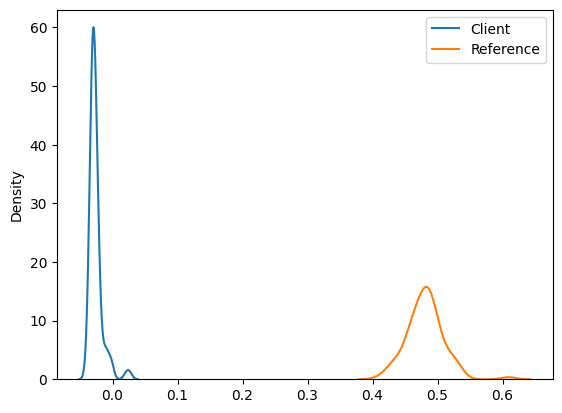

In [ ]:
kde_plot(df_0_controller, df_0_client, 0)

In [ ]:
df_1_client_784_1567 = df_1_client.iloc[:, 784:1567]
df_1_controller_784_1567 = df_1_controller.iloc[:,784:1567]

In [ ]:
df_1_client_784_1567.std().nlargest(10)


,0
1527,0.005164
1237,0.003517
1537,0.003196
1247,0.003025
1517,0.002637
1557,0.002131
1297,0.001955
1547,0.001931
1521,0.001672
1257,0.001544


In [ ]:
df_1_controller_784_1567.std().nlargest(10)


,0
1521,0.005698
1511,0.005273
1531,0.004631
1291,0.004445
1231,0.004004
1241,0.003932
1561,0.003879
1541,0.003872
1551,0.003432
1251,0.002713


#### Violin Plot

In [ ]:
p = pd.DataFrame(p)
q = pd.DataFrame(q)
df = pd.concat([p, q], axis=1)
df.columns = ['Client', 'Controller']
df

,Client,Controller
0,-0.000037,0.000189
1,-0.000086,0.000021
2,-0.000109,0.000107
3,-0.000090,0.000085
4,-0.000133,0.000092
5,-0.000110,0.000094
6,-0.000075,0.000173
7,-0.000133,0.000026
8,-0.000086,0.000161
9,-0.000166,0.000193


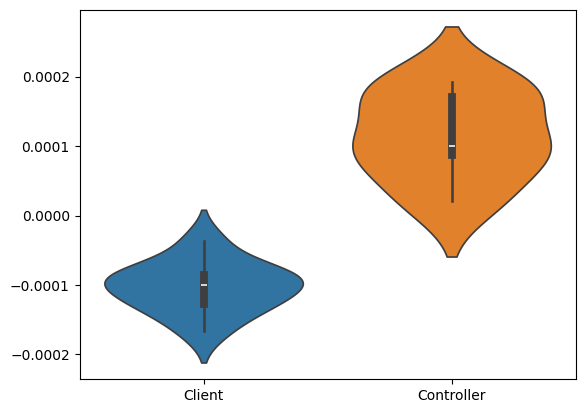

In [ ]:
import seaborn as sns
sns.violinplot(data=df)
plt.show()

# SHAP → t-SNE → JS Divergence

In [ ]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import plotly.express as px

# Assuming 'df' is your DataFrame with shape (10, number of features)

perplexity = np.arange(1, min(55, df_0_client_0_783.shape[0]), 1)  # Ensure perplexity is less than n_samples
divergence = []

for i in perplexity:
    model = TSNE(n_components=3, init="pca", perplexity=i)
    reduced = model.fit_transform(df_0_client_0_783)
    divergence.append(model.kl_divergence_)

fig = px.line(x=perplexity, y=divergence, markers=True)
fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
fig.update_traces(line_color="red", line_width=1)
fig.show()

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3,perplexity = 8)
X_train_tsne_client_0_0_783 = tsne.fit_transform(df_0_client_0_783)

tsne.kl_divergence_

0.30074542760849

In [ ]:
# Access the first column using .iloc for integer-based indexing
X_train_tsne_client_0_0_783 = pd.DataFrame(X_train_tsne_client_0_0_783)
X_train_tsne_client_0_0_783

,0,1,2
0,169.464523,31.301298,91.583221
1,27.196804,10.932178,-3.976638
2,-114.750511,-15.793110,35.744141
3,-10.586585,-54.444542,143.508026
4,-64.419388,112.741989,-88.668831
5,-114.860886,-38.975395,-128.395767
6,0.537841,161.664246,71.401466
7,-256.719818,-28.942640,0.719789
8,-6.575057,-142.280228,-62.155918
9,154.963989,-54.809536,-94.104866


In [ ]:
X_train_tsne_client_0_0_783 = pd.DataFrame(X_train_tsne_client_0_0_783)
X_train_tsne_client_0_0_783

,0,1,2
0,169.464523,31.301298,91.583221
1,27.196804,10.932178,-3.976638
2,-114.750511,-15.793110,35.744141
3,-10.586585,-54.444542,143.508026
4,-64.419388,112.741989,-88.668831
5,-114.860886,-38.975395,-128.395767
6,0.537841,161.664246,71.401466
7,-256.719818,-28.942640,0.719789
8,-6.575057,-142.280228,-62.155918
9,154.963989,-54.809536,-94.104866


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3,perplexity = 8)
X_train_tsne_controller_0_0_783 = tsne.fit_transform(df_0_controller_0_783)

tsne.kl_divergence_

0.2560358941555023

In [ ]:
X_train_tsne_controller_0_0_783 = pd.DataFrame(X_train_tsne_controller_0_0_783)
X_train_tsne_controller_0_0_783

,0,1,2
0,-43.266312,-158.834869,-99.376457
1,-120.042618,54.973785,122.059830
2,-15.156116,12.707561,-142.172653
3,-59.615726,94.733253,-31.888851
4,30.207184,129.956726,116.246277
5,-45.502792,-70.802750,54.964676
6,84.513878,-79.731514,158.543182
7,-176.216904,-22.917315,-19.218826
8,75.214531,-73.914886,-44.565868
9,137.282928,39.110470,22.967403


In [ ]:

distance.jensenshannon(np.array(X_train_tsne_client_0_0_783[2]), np.array(X_train_tsne_controller_0_0_783[2]), axis=0)

inf

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy

# Helper function to compute JS Divergence between two distributions
def js_divergence(P, Q):
    # Convert arrays to numpy arrays (in case they're not)
    P = np.array(P)
    Q = np.array(Q)

    # Normalize to ensure they are valid probability distributions
    # P = P / np.sum(P)
    # Q = Q / np.sum(Q)

    # Calculate the average distribution M
    M = 0.5 * (P + Q)

    # Compute the KL divergence between P and M, and Q and M
    kl_P_M = entropy(P, M)  # KL Divergence P || M
    kl_Q_M = entropy(Q, M)  # KL Divergence Q || M

    # JS Divergence is the average of the two KL divergences
    jsd = 0.5 * (kl_P_M + kl_Q_M)

    return jsd


# # Perform t-SNE dimensionality reduction
# tsne = TSNE(n_components=3,perplexity=8)
# tsne_results = tsne.fit_transform(df_0_controller_0_783)

p = pd.DataFrame(X_train_tsne_client_0_0_783[2])
q = pd.DataFrame(X_train_tsne_controller_0_0_783[2])
df = pd.concat([p, q], axis=1)
df.columns = ['Client', 'Controller']


# Compute pairwise distances in t-SNE space
pairwise_distances = squareform(pdist(df, 'euclidean'))

# Convert distances to probability distributions (e.g., using softmax)
def softmax(x):
    return np.exp(-x) / np.sum(np.exp(-x), axis=0)

# Create probability distributions from the distances
prob_distributions = np.apply_along_axis(softmax, 1, pairwise_distances)

# Select two points (e.g., first two rows) and compute JS Divergence between them
P = prob_distributions[0]  # Probability distribution for point 1
Q = prob_distributions[1]  # Probability distribution for point 2

# Compute JS Divergence between the two probability distributions
jsd_value = js_divergence(P, Q)

print(f"JS Divergence between two t-SNE points: {jsd_value}")


JS Divergence between two t-SNE points: 0.6931471805599453


In [ ]:
def jensenshannon(p, q, base=None, *, axis=0, keepdims=False):
    """
    Compute the Jensen-Shannon distance (metric) between
    two probability arrays. This is the square root
    of the Jensen-Shannon divergence.

    The Jensen-Shannon distance between two probability
    vectors `p` and `q` is defined as,

    .. math::

       \\sqrt{\\frac{D(p \\parallel m) + D(q \\parallel m)}{2}}

    where :math:`m` is the pointwise mean of :math:`p` and :math:`q`
    and :math:`D` is the Kullback-Leibler divergence.

    This routine will normalize `p` and `q` if they don't sum to 1.0.

    Parameters
    ----------
    p : (N,) array_like
        left probability vector
    q : (N,) array_like
        right probability vector
    base : double, optional
        the base of the logarithm used to compute the output
        if not given, then the routine uses the default base of
        scipy.stats.entropy.
    axis : int, optional
        Axis along which the Jensen-Shannon distances are computed. The default
        is 0.

        .. versionadded:: 1.7.0
    keepdims : bool, optional
        If this is set to `True`, the reduced axes are left in the
        result as dimensions with size one. With this option,
        the result will broadcast correctly against the input array.
        Default is False.

        .. versionadded:: 1.7.0

    Returns
    -------
    js : double or ndarray
        The Jensen-Shannon distances between `p` and `q` along the `axis`.

    Notes
    -----

    .. versionadded:: 1.2.0

    Examples
    --------
    >>> from scipy.spatial import distance
    >>> import numpy as np
    >>> distance.jensenshannon([1.0, 0.0, 0.0], [0.0, 1.0, 0.0], 2.0)
    1.0
    >>> distance.jensenshannon([1.0, 0.0], [0.5, 0.5])
    0.46450140402245893
    >>> distance.jensenshannon([1.0, 0.0, 0.0], [1.0, 0.0, 0.0])
    0.0
    >>> a = np.array([[1, 2, 3, 4],
    ...               [5, 6, 7, 8],
    ...               [9, 10, 11, 12]])
    >>> b = np.array([[13, 14, 15, 16],
    ...               [17, 18, 19, 20],
    ...               [21, 22, 23, 24]])
    >>> distance.jensenshannon(a, b, axis=0)
    array([0.1954288, 0.1447697, 0.1138377, 0.0927636])
    >>> distance.jensenshannon(a, b, axis=1)
    array([0.1402339, 0.0399106, 0.0201815])

    """
    p = np.asarray(p)
    q = np.asarray(q)
    p = p / np.sum(p, axis=axis, keepdims=True)
    q = q / np.sum(q, axis=axis, keepdims=True)
    m = (p + q) / 2.0
    left = rel_entr(p, m)
    right = rel_entr(q, m)
    left_sum = np.sum(left, axis=axis, keepdims=keepdims)
    right_sum = np.sum(right, axis=axis, keepdims=keepdims)
    js = left_sum + right_sum
    if base is not None:
        js /= np.log(base)
    return np.sqrt(js / 2.0)

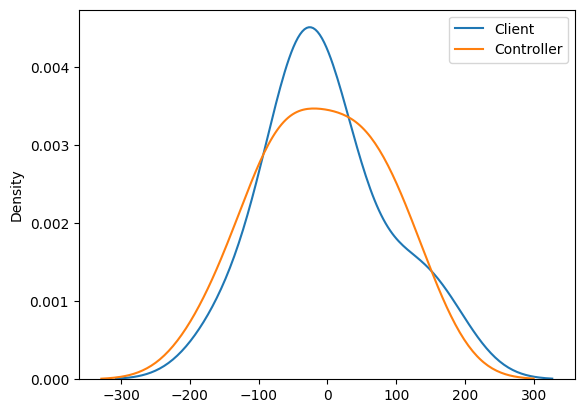

In [ ]:
p = np.array(X_train_tsne_client_0_0_783[1])
q = np.array(X_train_tsne_controller_0_0_783[1])
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(p,label='Client')
sns.kdeplot(q,label='Controller')
plt.legend()
plt.show()

In [ ]:
js_divergence(X_train_tsne_client_0_0_783[2], X_train_tsne_controller_0_0_783[2])


inf

#Grad Cam


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(inputs = model.input, outputs = [model.get_layer(last_conv_layer_name).output, model.output])

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
import random
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
def plot_gradcam_results (model, images, labels, model_layer):
    model.layers[-1].activation = None
    for i in range(len(images)):
        # batch_images, batch_labels = random.choice(data)
        # batch_image = batch_images[:num_image]  # Take the first image from the batch
        # batch_label = batch_labels[:num_image]  # Corresponding label
        img_array = images[i]
        image = np.expand_dims(img_array, axis=0)

        # Make the prediction
        prediction = model.predict(image)

        # Create the heatmap
        heatmap = make_gradcam_heatmap(image, model, model_layer)

        # Resize the heatmap to the original image size
        heatmap = tf.expand_dims(heatmap, axis=-1)  # Add an extra channel dimension
        heatmap = tf.image.resize(heatmap, (img_array.shape[0], img_array.shape[1]))

        # Convert the heatmap to numpy array
        heatmap = heatmap.numpy()
        heatmap = np.abs(heatmap-1) # Red and blue are reversed, probably because cv2 and tensorflow dont use the same default colors - This will make them appear as I want

        # Normalize the heatmap
        heatmap = np.uint8(255 * heatmap)

        # Apply colormap (jet or any other)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Convert heatmap to float32 and scale to [0, 1]
        heatmap = heatmap.astype(np.float32) / 255

        # Superimpose both images
        superimposed_img = cv2.addWeighted(img_array, 0.5, heatmap, 0.5, 0)

        # Get predicted and true labels
        true_label = labels[i]
        true_class_name = true_label
        predicted_label = np.argmax(prediction[0])
        predicted_class_name = predicted_label
        title_color = 'green' if true_label == predicted_label else 'red'

        # Plot the original image and the Grad-CAM heatmap
        plt.figure(figsize=(15, 5))
        plt.suptitle('Image {} - Predicted label: {} | True label: {}'.format(i+1, predicted_class_name, true_class_name), fontsize=16, x=0.5, y=0.98, horizontalalignment='right', color=title_color)
        plt.subplot(1, 2, 1)
        plt.imshow(img_array)
        plt.title('Original')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(superimposed_img)
        plt.title('Grad-CAM Heatmap')
        plt.axis('off')

        plt.show()

In [ ]:
model.build((None, 28, 28, 3))

In [ ]:
labels = []
for i in range(5):
  labels.append(4)

In [ ]:
import numpy as np

# Assuming you have already defined your model
input_data = np.random.random((1, 28, 28, 3))  # A dummy input with the correct shape
model(input_data)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.17074364, -0.4850129 ,  0.46239656, -0.24207683, -0.2589527 ,
        -0.8459648 , -0.8402818 , -0.3355302 ,  1.3787056 , -0.05601056]],
      dtype=float32)>

In [ ]:
def last_conv_layer(model):
  for layer in reversed(model.layers):
    if ('conv2d' in layer.name):
      return layer.name

In [ ]:
layer = last_conv_layer(model)
layer

'conv2d_1'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


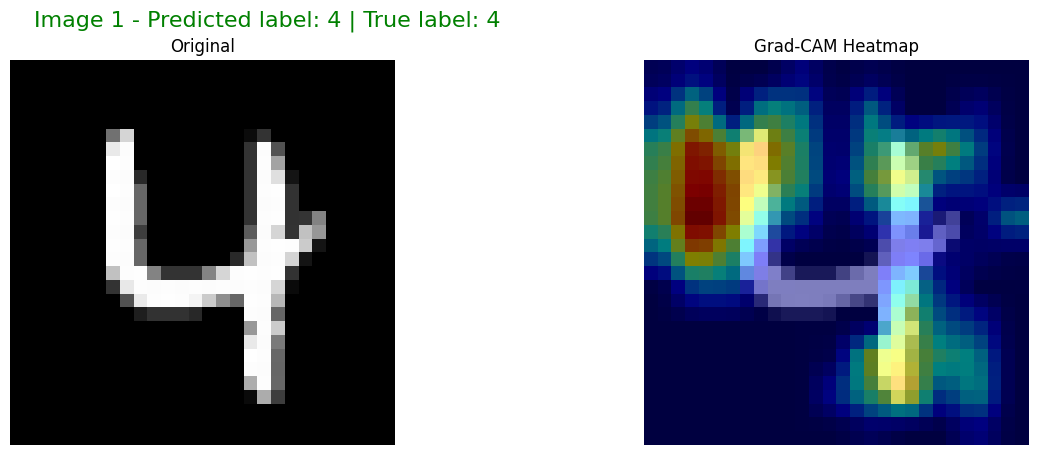

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


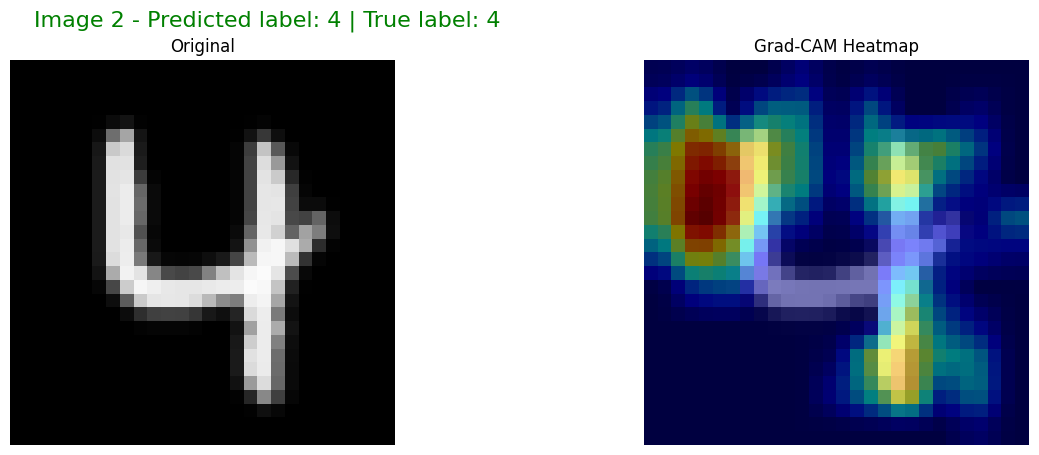

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


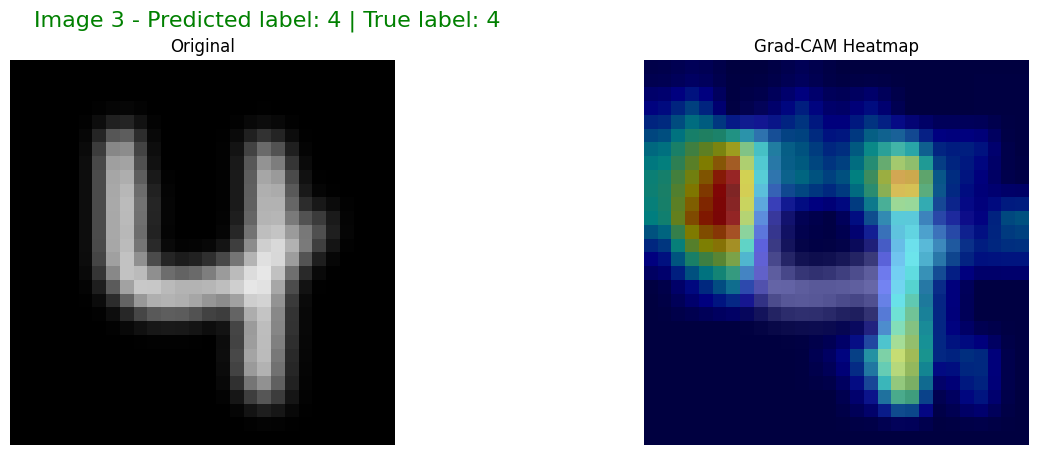

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


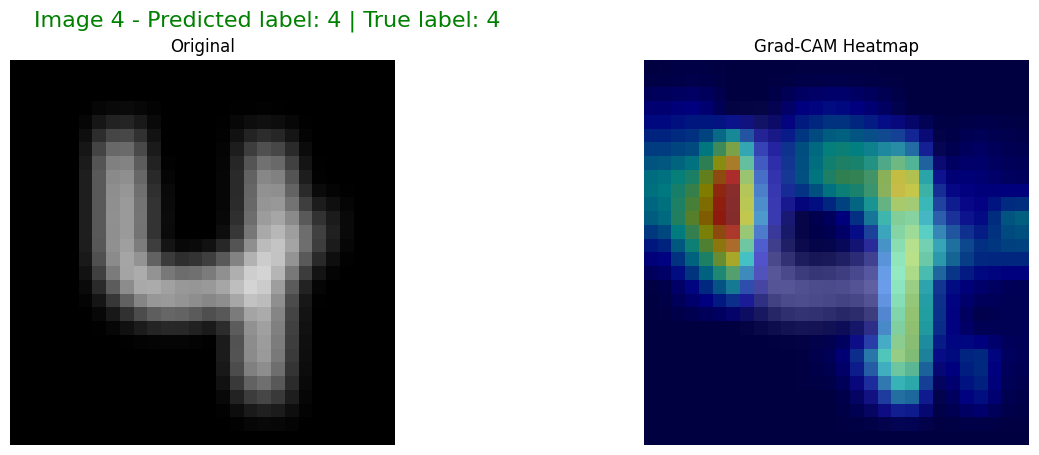

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


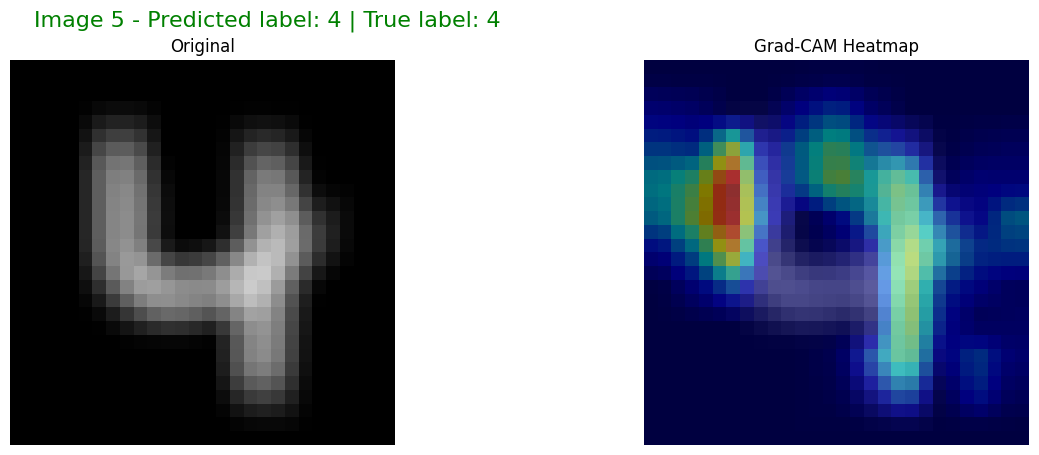

In [ ]:
plot_gradcam_results(model,noise_images_list,labels,last_conv_layer(model))

#Intersection Over Union(IOU)

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import tensorflow.keras.backend as K
import shap
import matplotlib.pyplot as plt

In [ ]:
def generate_gradcam(model, image, class_idx , layer):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(conv_outputs.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (28, 28))

    return heatmap

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(inputs = model.input, outputs = [model.get_layer(last_conv_layer_name).output, model.output])

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = cv2.resize(heatmap, (28, 28))
    return heatmap.numpy()

In [ ]:
y_test[1]

2

In [ ]:
# Prepare ground truth binary masks (for MNIST dataset)
def create_ground_truth_mask(image):
    binary_mask = image > 0  # Binary mask where pixel values > 0 are set to 1 (assuming digits are non-zero)
    return binary_mask.astype(np.float32)

# Load an image from the MNIST dataset
img = X_test[1][tf.newaxis, ...]
ground_truth_mask = create_ground_truth_mask(X_test[0])



In [ ]:
img = X_test[1][tf.newaxis, ...]

In [ ]:
img1 = X_test1[0][tf.newaxis, ...]

In [ ]:
class_idx = np.argmax(model.predict(img))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [ ]:



# Generate Grad-CAM heatmap
gradcam_heatmap = generate_gradcam(model, img, class_idx ,"conv2d_3")




In [ ]:
gradcam_heatmap

array([[0.00000000e+00, 1.79797586e-03, 9.70906951e-03, 1.76201630e-02,
        1.07085772e-01, 2.34610155e-01, 3.69858950e-01, 5.54028988e-01,
        7.38198996e-01, 8.08647633e-01, 8.00366104e-01, 7.81119049e-01,
        5.31597018e-01, 2.82074988e-01, 1.26412988e-01, 6.46110773e-02,
        2.80917622e-03, 0.00000000e+00, 0.00000000e+00, 1.32468594e-02,
        4.56280671e-02, 7.80092850e-02, 5.44593111e-02, 2.20780987e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.91124755e-03, 1.57207381e-02, 2.85302270e-02,
        1.14953391e-01, 2.35729620e-01, 3.63887906e-01, 5.38799226e-01,
        7.13710546e-01, 7.71347106e-01, 7.47793436e-01, 7.15037286e-01,
        4.89029258e-01, 2.63021231e-01, 1.20549522e-01, 6.16141967e-02,
        2.67887698e-03, 0.00000000e+00, 0.00000000e+00, 1.20641040e-02,
        4.15541306e-02, 7.10441694e-02, 4.95968722e-02, 2.01068390e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000

In [ ]:
gradcam_heatmap.shape

(28, 28)

In [ ]:
# Take a random sample of 100 training images
background = X_train[np.random.choice(X_train.shape[0] , 100 , replace = False)]

In [ ]:
# SHAP analysis
def generate_shap(model , img , class_idx):
  explainer = shap.DeepExplainer(model, background)  # Use a subset for SHAP training
  shap_values = explainer.shap_values(img)  # Get SHAP values for each class
  shap_values = np.array(shap_values)
  shap_values = np.transpose(shap_values, (0, 4,1, 2, 3))
  shap_image = shap_values[0][class_idx]
  return shap_image




In [ ]:
new_arr = shap_image.reshape(784, 3)

In [ ]:
import pandas as pd
df = pd.DataFrame(new_arr)
df.to_csv('shap.csv', index=False)

In [ ]:
shap_image = generate_shap(model , img , class_idx)

In [ ]:
shap_image.shape

(28, 28, 1)

In [ ]:
shap_image = new_arr[0][7]

In [ ]:
# Normalize
gradcam_heatmap_normalized = gradcam_heatmap / np.max(gradcam_heatmap)
shap_image_normalized = shap_image / np.max(shap_image)

# Convert to binary maps (thresholding)
gradcam_binary = gradcam_heatmap_normalized > 0.5
shap_binary = shap_image_normalized > 0.5

# Calculate Intersection over Union (IoU) between Grad-CAM and SHAP binary maps
intersection = np.logical_and(gradcam_binary, shap_binary)
union = np.logical_or(gradcam_binary, shap_binary)
iou = np.sum(intersection) / np.sum(union)
print(f"IoU between Grad-CAM and SHAP: {iou}")

# Calculate Intersection over Union (IoU) with ground truth mask (for both Grad-CAM and SHAP)
intersection_gradcam = np.logical_and(gradcam_binary, ground_truth_mask)
union_gradcam = np.logical_or(gradcam_binary, ground_truth_mask)
iou_gradcam_gt = np.sum(intersection_gradcam) / np.sum(union_gradcam)
print(f"IoU between Grad-CAM and Ground Truth: {iou_gradcam_gt}")

intersection_shap = np.logical_and(shap_binary, ground_truth_mask)
union_shap = np.logical_or(shap_binary, ground_truth_mask)
iou_shap_gt = np.sum(intersection_shap) / np.sum(union_shap)
print(f"IoU between SHAP and Ground Truth: {iou_shap_gt}")

# Compute Cosine Similarity between Grad-CAM and SHAP heatmaps
gradcam_flat = gradcam_heatmap_normalized.flatten()
shap_flat = shap_image_normalized.flatten()
cosine_similarity = np.dot(gradcam_flat, shap_flat) / (np.linalg.norm(gradcam_flat) * np.linalg.norm(shap_flat))
print(f"Cosine Similarity: {cosine_similarity}")



IoU between Grad-CAM and SHAP: 0.009197116579666915
IoU between Grad-CAM and Ground Truth: 0.03194103194103194
IoU between SHAP and Ground Truth: 0.008264462809917356
Cosine Similarity: 0.2854848222626032


In [ ]:
shap_binary.shape

(28, 28, 1)

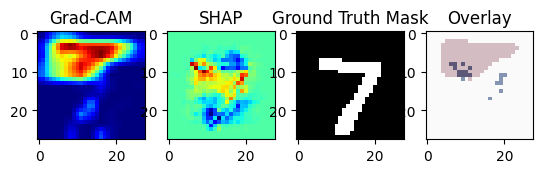

In [ ]:
# Visualize the results
plt.subplot(1, 4, 1)
plt.imshow(gradcam_heatmap_normalized, cmap='jet')
plt.title("Grad-CAM")

plt.subplot(1, 4, 2)
plt.imshow(shap_image_normalized, cmap='jet')
plt.title("SHAP")

plt.subplot(1, 4, 3)
plt.imshow(ground_truth_mask, cmap='gray')
plt.title("Ground Truth Mask")

plt.subplot(1, 4, 4)
plt.imshow(gradcam_binary, alpha=0.5, cmap='Reds')
plt.imshow(shap_binary, alpha=0.5, cmap='Blues')
plt.title("Overlay")
plt.show()

##IOU 2.0

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf
# import cv2

# # Function to generate Grad-CAM heatmap
# def generate_gradcam(model, image, layer_name, class_idx):
#     grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
#     with tf.GradientTape() as tape:
#         conv_outputs, predictions = grad_model(image)
#         loss = predictions[:, class_idx]

#     grads = tape.gradient(loss, conv_outputs)
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

#     conv_outputs = conv_outputs[0]
#     heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

#     # Normalize heatmap between 0 and 1
#     heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
#     heatmap = np.expand_dims(heatmap, axis=-1)
#     heatmap = cv2.resize(heatmap, (28, 28))
#     return heatmap

# # Assuming you have a single image as input
# image = X_test[0:1]  # Example test image
# layer_name = 'conv2d_1'  # The layer from which to extract the heatmap
# class_idx = np.argmax(model.predict(image))

# gradcam_heatmap = generate_gradcam(model, image, layer_name, class_idx)

# # Display the heatmap
# plt.imshow(gradcam_heatmap.squeeze(), cmap='jet')
# plt.show()


In [ ]:
y_test[1]

2

In [ ]:
 image = X_test[4:5]

In [ ]:
y_test[4:5]

array([4], dtype=uint8)

In [ ]:
np.array(image).shape

(1, 28, 28, 1)

In [ ]:
X_test[0].shape

(28, 28, 1)

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    # Compute the gradient of the top predicted class with respect to the activations
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap to range [0, 1]
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    # Resize the heatmap to (28, 28)
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (28, 28))  # Reshape to (28, 28)
    heatmap = tf.squeeze(heatmap)  # Remove extra channel dimension

    return heatmap.numpy()


In [ ]:
def last_conv_layer(model):
  for layer in reversed(model.layers):
    if ('conv2d' in layer.name):
      return layer.name

In [ ]:
gradcam_heatmap =make_gradcam_heatmap(image, model, last_conv_layer(model))

In [ ]:
# Take a random sample of 100 training images
background = X_train[np.random.choice(X_train.shape[0] , 100 , replace = False)]

In [ ]:
import shap
def create_shap_heatmap(model, image, background):

  # Initialize a SHAP explainer with your model
  explainer = shap.DeepExplainer(model, background)  # Use a subset of training data

  # Calculate SHAP values for the test image
  shap_values = explainer.shap_values(image)

  # Sum over SHAP values across all channels for a heatmap
  shap_heatmap = np.mean(np.abs(shap_values[0]), axis=-1)

  # Normalize SHAP heatmap between 0 and 1
  shap_heatmap = shap_heatmap / np.max(shap_heatmap)
  return shap_heatmap
  # # Display the SHAP heatmap
  # plt.imshow(shap_heatmap.squeeze(), cmap='jet')
  # plt.show()


In [ ]:
# Prepare ground truth binary masks (for MNIST dataset)
def create_ground_truth_mask(image):
    binary_mask = image > 0  # Binary mask where pixel values > 0 are set to 1 (assuming digits are non-zero)
    return binary_mask.astype(np.float32)

# Load an image from the MNIST dataset
# img = X_test[1][tf.newaxis, ...]
# ground_truth_mask = create_ground_truth_mask(X_test[2])

In [ ]:
def specific_label_test(label, count , X_test):
  """
  Returns a list of images with the given label

  label : label of the image
  count : number of images
  """
  X_test_final = []
  c = 0
  for i in range(len(X_test)):
    if y_test[i] == label:
      c += 1
      X_test_final.append(X_test[i])
      if c == count:
  	    break

  return X_test_final

In [ ]:
X_test_final = specific_label_test(7, 10 , X_test)

In [ ]:
sigma_list = [0.1 , 0.5 , 1 , 1.5 , 2]

In [ ]:
import cv2
def noise_images(image):
  X_test_final = []
  for i in range(len(sigma_list)):
      img_noise = cv2.GaussianBlur(image,(5,5),sigma_list[i])
      img_noise = img_noise.reshape(28,28,1)
      X_test_final.append(img_noise)
  X_test_final = np.array(X_test_final)
  return X_test_final

In [ ]:
noise_images_list = noise_images(X_test_final[0])

In [ ]:
def IOU_compute(gradcam_heatmap, shap_heatmap, ground_truth_mask):

    # # Example ground truth mask for the test image (Assuming binary mask)
    # ground_truth_mask = np.random.randint(0, 2, size=(28, 28))  # Replace with actual mask

    # Threshold heatmaps to create binary masks
    threshold = 0.5  # You can tune this value
    gradcam_binary = (gradcam_heatmap.squeeze() > threshold).astype(int)
    shap_binary = (shap_heatmap.squeeze() > threshold).astype(int)

    # IoU calculation function
    def compute_iou(mask1, mask2):
        intersection = np.logical_and(mask1, mask2).sum()
        union = np.logical_or(mask1, mask2).sum()
        iou = intersection / union
        return iou

    # IoU between Grad-CAM and ground truth
    iou_gradcam = compute_iou(gradcam_binary, ground_truth_mask)

    # IoU between SHAP and ground truth
    iou_shap = compute_iou(shap_binary, ground_truth_mask)


    print(f"IoU (Grad-CAM vs Ground Truth): {iou_gradcam}")
    print(f"IoU (SHAP vs Ground Truth): {iou_shap}")

    return iou_gradcam, iou_shap



In [ ]:
gradcam_iou_list = []
shap_iou_list = []
ground_truth_mask = create_ground_truth_mask(X_test_final[0])
for i in range(len(noise_images_list)):
  gradcam_heatmap = make_gradcam_heatmap(noise_images_list[i:i+1], model, last_conv_layer(model))
  shap_heatmap = create_shap_heatmap(model, noise_images_list[i:i+1], background)
  iou_gradcam, iou_shap = IOU_compute(gradcam_heatmap, shap_heatmap, ground_truth_mask)
  gradcam_iou_list.append(iou_gradcam)
  shap_iou_list.append(iou_shap)
print(gradcam_iou_list)
print(shap_iou_list)


/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


IoU (Grad-CAM vs Ground Truth): 0.05334394904458599
IoU (SHAP vs Ground Truth): 0.00529723366686286
IoU (Grad-CAM vs Ground Truth): 0.057032677085447535
IoU (SHAP vs Ground Truth): 0.0035842293906810036
IoU (Grad-CAM vs Ground Truth): 0.0752851711026616
IoU (SHAP vs Ground Truth): 0.04831773336706299
IoU (Grad-CAM vs Ground Truth): 0.032707028531663185
IoU (SHAP vs Ground Truth): 0.011743450767841012
IoU (Grad-CAM vs Ground Truth): 0.03046551303923958
IoU (SHAP vs Ground Truth): 0.02074688796680498
[0.05334394904458599, 0.057032677085447535, 0.0752851711026616, 0.032707028531663185, 0.03046551303923958]
[0.00529723366686286, 0.0035842293906810036, 0.04831773336706299, 0.011743450767841012, 0.02074688796680498]


In [ ]:
import random
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    # Compute the gradient of the top predicted class with respect to the activations
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap to range [0, 1]
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def plot_gradcam_results(model, images, labels, model_layer):
    model.layers[-1].activation = None  # Disable softmax for heatmap generation
    for i in range(len(images)):
        img_array = images[i]
        image = np.expand_dims(img_array, axis=0)  # Expand to batch format

        # Make the prediction
        prediction = model.predict(image)

        # Create the heatmap
        heatmap = make_gradcam_heatmap(image, model, model_layer)

        # Resize the heatmap to the original image size
        heatmap = tf.expand_dims(heatmap, axis=-1)  # Add channel dimension to heatmap
        heatmap = tf.image.resize(heatmap, (img_array.shape[0], img_array.shape[1]))

        # Convert heatmap to numpy array and normalize
        heatmap = heatmap.numpy()
        heatmap = np.uint8(255 * heatmap)

        # Apply colormap (jet or any other)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Convert grayscale image to 3-channel format for superimposing
        img_array_3ch = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)

        # Superimpose heatmap onto the grayscale image
        heatmap = heatmap.astype(np.float32) / 255
        superimposed_img = cv2.addWeighted(img_array_3ch, 0.5, heatmap, 0.5, 0)

        # Get predicted and true labels
        true_label = labels[i]
        predicted_label = np.argmax(prediction[0])
        title_color = 'green' if true_label == predicted_label else 'red'

        # Plot the original image and the Grad-CAM heatmap
        plt.figure(figsize=(15, 5))
        plt.suptitle('Image {} - Predicted label: {} | True label: {}'.format(i + 1, predicted_label, true_label), fontsize=16, x=0.5, y=0.98, horizontalalignment='right', color=title_color)

        plt.subplot(1, 2, 1)
        plt.imshow(img_array.squeeze(), cmap='gray')  # Grayscale image
        plt.title('Original')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(superimposed_img)
        plt.title('Grad-CAM Heatmap')
        plt.axis('off')

        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


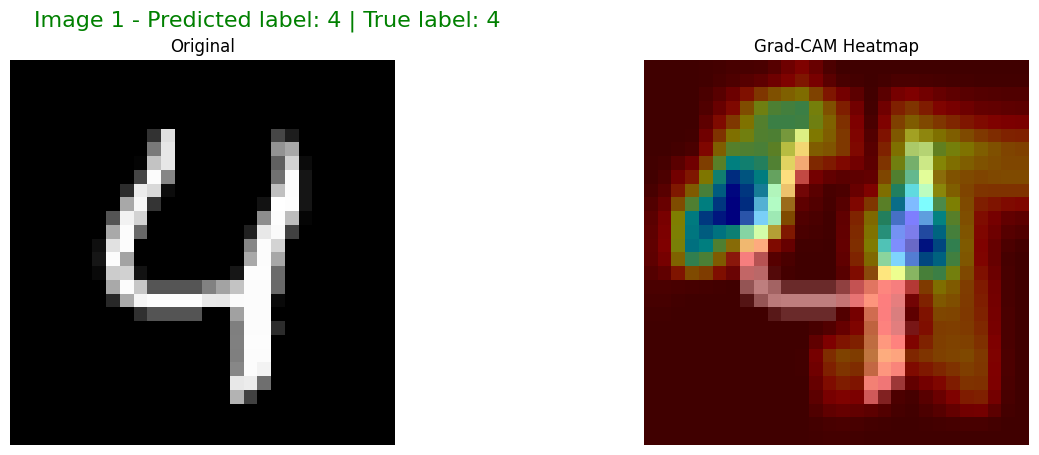

In [ ]:
plot_gradcam_results(model, image, [4], 'conv2d_1')

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(inputs=model.input,
                                    outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Mean intensity of the gradient over each feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array
    # by its importance for the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

def plot_gradcam_results(model, images, labels, model_layer):
    model.layers[-1].activation = None  # Disable softmax activation

    for i in range(len(images)):
        img_array = images[i]

        # Ensure the image has a single channel (grayscale)
        assert img_array.shape == (28, 28, 1), "Input image should have shape (28, 28, 1)"

        image = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make the prediction
        prediction = model.predict(image)

        # Create the heatmap
        heatmap = make_gradcam_heatmap(image, model, model_layer)

        # Resize the heatmap to the original image size
        heatmap = tf.expand_dims(heatmap, axis=-1)  # Add an extra channel dimension
        heatmap = tf.image.resize(heatmap, (img_array.shape[0], img_array.shape[1]))

        # Convert the heatmap to numpy array
        heatmap = heatmap.numpy()

        # Normalize the heatmap
        heatmap = np.uint8(255 * heatmap)

        # Apply colormap (jet or any other)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Convert heatmap to float32 and scale to [0, 1]
        heatmap = heatmap.astype(np.float32) / 255

        # Convert grayscale image (single channel) to 3 channels for superimposing
        img_array_rgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)

        # Superimpose both images
        superimposed_img = cv2.addWeighted(img_array_rgb, 0.5, heatmap, 0.5, 0)

        # Get predicted and true labels
        true_label = labels[i]
        predicted_label = np.argmax(prediction[0])

        true_class_name = true_label
        predicted_class_name = predicted_label
        title_color = 'green' if true_label == predicted_label else 'red'

        # Plot the original image and the Grad-CAM heatmap
        plt.figure(figsize=(15, 5))
        plt.suptitle(f'Image {i+1} - Predicted label: {predicted_class_name} | True label: {true_class_name}',
                     fontsize=16, x=0.5, y=0.98, horizontalalignment='right', color=title_color)

        plt.subplot(1, 2, 1)
        plt.imshow(np.squeeze(images[i]), cmap='gray')  # Plot as grayscale
        plt.title('Original')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(superimposed_img)
        plt.title('Grad-CAM Heatmap')
        plt.axis('off')

        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


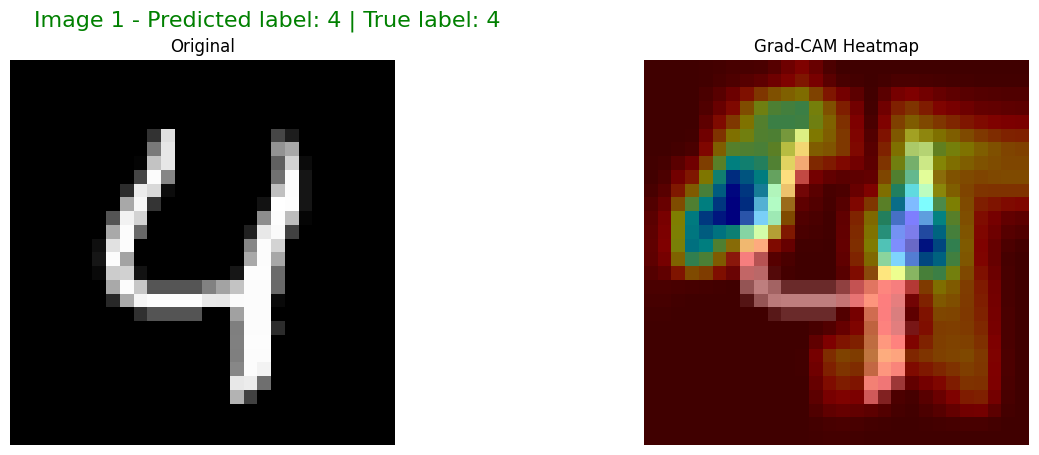

In [ ]:
plot_gradcam_results(model, image, [4], 'conv2d_1')

##Performance drop after Perturbation Test

In [ ]:
import numpy as np
import tensorflow as tf
def perturb_image(image, importance_map, k_percent, k="shap", method="zero_out"):
    # Get the most important pixels or regions (top k% pixels)
    num_pixels = int(k_percent * image.size)
    # Sort importance map based on importance scores
    if k == "shap":
      important_pixels = np.argsort(np.abs(importance_map.ravel()))[-num_pixels:]
    else:
      important_pixels = np.argsort(importance_map.ravel())[-num_pixels:]

    perturbed_image = image.copy()

    if method == "zero_out":
        # Zero out the top k% most important pixels
        perturbed_image.ravel()[important_pixels] = 0
    # elif method == "gaussian_blur":
    #     # Apply Gaussian blur to the top k% region
    #     perturbed_image = apply_gaussian_blur(perturbed_image, important_pixels)
    elif method == "random_noise":
        # Add random noise to the top k% region
        perturbed_image.ravel()[important_pixels] = np.random.rand(num_pixels)
    elif method == 'mean':
        perturbed_image.ravel()[important_pixels] = np.mean(image)

    return perturbed_image

def measure_performance_drop(model, image, perturbed_image, target_class):
    # Get model predictions for original and perturbed images
    original_pred = model.predict(image)
    perturbed_pred = model.predict(perturbed_image)
    # print(original_pred[0])
    # Measure the confidence drop for the target class
    performance_drop = (original_pred[0][target_class] - perturbed_pred[0][target_class]) * 100

    return performance_drop




In [ ]:
def specific_label_test(label, count , X_test):
  """
  Returns a list of images with the given label

  label : label of the image
  count : number of images
  """
  X_test_final = []
  c = 0
  for i in range(len(X_test)):
    if y_test[i] == label:
      c += 1
      X_test_final.append(X_test[i])
      if c == count:
  	    break

  return np.array(X_test_final)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
SHAP Performance Drop: 97.56135940551758%
Grad-CAM Performance Drop: 0.0%


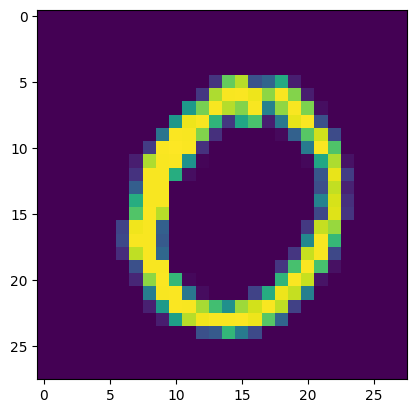

In [ ]:
import matplotlib.pyplot as plt

label = 0
X_test_final = specific_label_test(label, 10, X_test)
image = X_test_final[8:9]
plt.imshow(image[0])

# Generate SHAP and Grad-CAM explanations
shap_explanation = create_shap_heatmap(model, image, background)
gradcam_explanation = make_gradcam_heatmap(image, model, last_conv_layer(model))

# Perform perturbation test on SHAP and Grad-CAM explanations
perturbed_image_shap = perturb_image(image, shap_explanation, k_percent=0.10,k="shap")
perturbed_image_gradcam = perturb_image(image, gradcam_explanation, k_percent=0.10,k="grad_cam")

# Measure performance drops
shap_drop = measure_performance_drop(model, image, perturbed_image_shap, label)
gradcam_drop = measure_performance_drop(model, image, perturbed_image_gradcam, label)

# Compare results
print(f'SHAP Performance Drop: {shap_drop}%')
print(f'Grad-CAM Performance Drop: {gradcam_drop}%')

In [ ]:
def get_top_k_percent_shap(shap_values, k_percent):
    # Flatten SHAP values
    flattened_shap = shap_values.ravel()

    # Get the number of pixels to keep
    num_pixels = int(len(flattened_shap) * k_percent / 100)

    # Rank pixels by importance (absolute SHAP values)
    top_k_indices = np.argsort(np.abs(flattened_shap))[-num_pixels:]

    return top_k_indices


In [ ]:
def get_top_k_percent_gradcam(gradcam_heatmap, image_size, k_percent):
    # Upsample Grad-CAM heatmap to match image size
    upsampled_heatmap = cv2.resize(gradcam_heatmap, image_size, interpolation=cv2.INTER_LINEAR)

    # Flatten the heatmap
    flattened_heatmap = upsampled_heatmap.ravel()

    # Get the number of pixels to keep
    num_pixels = int(len(flattened_heatmap) * k_percent / 100)

    # Rank pixels by importance (heatmap values)
    top_k_indices = np.argsort(flattened_heatmap)[-num_pixels:]

    return top_k_indices


#Client end Cosine similarity

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Resizing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Define the CNN model
def create_model():
    # Initialize the input
    input_layer = tf.keras.Input(shape=(28, 28, 1))

    # First convolutional layer
    conv1 = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    # Second convolutional layer
    conv2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    # Dropout to prevent overfitting
    dropout1 = layers.Dropout(0.25)(pool2)

    # Flatten the 3D tensor to 1D
    flatten = layers.Flatten()(dropout1)

    # Fully connected layers
    dense1 = layers.Dense(128, activation='relu')(flatten)
    dropout2 = layers.Dropout(0.5)(dense1)

    # Output layer for 10 classes
    output_layer = layers.Dense(10, activation='softmax')(dropout2)

    # Define the model
    model = models.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model (optional)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
label_flip = {
  0: 6,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 0,
  7: 7,
  8: 8,
  9: 9
}

In [ ]:
l = [12 , 15 , 19] #poisoned rounds

In [ ]:
l = [1 , 2, 3, 4, 5]
l[-3:]

[3, 4, 5]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def check_weights(model_weights , weights_list):
  num_layers = len(weights_list[0])
  client_weights = [np.mean([weights_list[k][layer] for k in range(len(weights_list))], axis=0) for layer in range(num_layers)]
  # Transform the weights into a flat structure
  model_weights_flat = [weights.flatten() for weights in model_weights]
  client_weights_flat = [weights.flatten() for weights in client_weights]

  # Stack the flattened weights to create a 2D array for cosine similarity calculation
  model_weights_2d = np.concatenate(model_weights_flat)
  client_weights_2d = np.concatenate(client_weights_flat)

  # Calculate the cosine similarity
  cosine_value = cosine_similarity([model_weights_2d], [client_weights_2d])[0][0]
  print(cosine_value)
  if cosine_value > 0.5:
    return True
  else:
    return False

In [ ]:

rounds =  20
dataset_list = []
weights_list = []
len_train = X_train.shape[0] // rounds

for i in range(1 , rounds + 1):
    print("Round :",i)
    start = (i-1) * len_train
    end = (i) * len_train
    subset_images = X_train[start:end]
    subset_labels = y_train[start:end]
    print(subset_labels)
    if i in l:
          for k in range(len(subset_labels)):
               subset_labels[k] = label_flip[subset_labels[k]]
    print(subset_labels)
    model = create_model()
    model.fit(subset_images, subset_labels, epochs=2 , batch_size=64, verbose=1)
    if(i <= 10):
      weights_list.append(model.get_weights())
    else:
        if(check_weights(model.get_weights() , weights_list[-10:])):
            weights_list.append(model.get_weights())
            print(i)


Round : 1
[5 0 4 ... 9 1 5]
[5 0 4 ... 9 1 5]
Epoch 1/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - accuracy: 0.3474 - loss: 1.9185
Epoch 2/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.8144 - loss: 0.5924
Round : 2
[9 0 8 ... 8 6 9]
[9 0 8 ... 8 6 9]
Epoch 1/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.3794 - loss: 1.8105
Epoch 2/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.8201 - loss: 0.5535
Round : 3
[6 0 1 ... 2 9 9]
[6 0 1 ... 2 9 9]
Epoch 1/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.3622 - loss: 1.8653
Epoch 2/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.8160 - loss: 0.5999
Round : 4
[6 7 9 ... 2 8 3]
[6 7 9 ... 2 8 3]
Epoch 1/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.3640 - loss: 1.8448
Epoch 2/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.8187 - loss: 0.5884
Round : 5
[7 4 6 ... 7 1 7]
[7 4 6 ... 7 1 7]
Epoch 1/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.3177 - loss: 1.9367
Epoch 2/2
47

In [ ]:
len(weights_list)

10

In [ ]:
!pip install shap
import shap
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Resizing
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity

# Load MNIST dataset
(X_train , y_train),(X_test , y_test) = keras.datasets.mnist.load_data()

# Reshape the data
X_train = X_train.reshape(60000, 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(10000, 28, 28, 1).astype('float32') / 255

# Define the CNN model
def create_model():
    model = models.Sequential([
        # First convolutional layer
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),

        # Second convolutional layer
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Dropout layers to reduce overfitting
        layers.Dropout(0.25),

        # Flatten the 3D tensor to 1D for fully connected layers
        layers.Flatten(),

        # Fully connected layers
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')  # Output layer with 10 classes (0-9)
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model
label_flip = {
  0: 6,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 0,
  7: 7,
  8: 8,
  9: 9
}
# Define the function check weights
def check_weights(model_weights , weights_list):
  num_layers = len(weights_list[0])

  # Check if all the layers have the same size
  for weights in weights_list :
    if len(weights) != num_layers:
      raise ValueError("All models must have the same number of layers.")
    for i in range(num_layers):
      if weights[i].shape != weights_list[0][i].shape:
        raise ValueError("Weights at layer " + str(i) + " have different shapes")

  # Compute the average of the weights in the list
  client_weights = [np.mean([weights_list[k][layer] for k in range(len(weights_list))], axis=0) for layer in range(num_layers)]

  # Transform the weights into a flat structure
  model_weights_flat = [weights.flatten() for weights in model_weights]
  client_weights_flat = [weights.flatten() for weights in client_weights]

  # Stack the flattened weights to create a 2D array for cosine similarity calculation
  model_weights_2d = np.stack(model_weights_flat)
  client_weights_2d = np.stack(client_weights_flat)

  # Calculate the cosine similarity
  cosine_value = cosine_similarity(model_weights_2d, client_weights_2d)[0][0]

  if cosine_value > 0.9:
    return True
  else:
    return False
l = [12 , 15 , 19] #poisoned rounds
# l = [1 , 2, 3, 4, 5]
# l[-3:]
rounds =  20
dataset_list = []
weights_list = []
len_train = X_train.shape[0] // rounds

for i in range(1 , rounds + 1):
    print("Round :",i)
    start = (i-1) * len_train #Changed to subtract 1
    end = i * len_train #changed to remove the +1
    subset_images = X_train[start:end]
    subset_labels = y_train[start:end]
    if i in l:
          for k in range(len(subset_labels)):
               subset_labels[k] = label_flip[subset_labels[k]]
    model = create_model()
    model.fit(subset_images, subset_labels, epochs=2 , batch_size=64, verbose=1)
    if(i <= 10):
      weights_list.append(model.get_weights())
    else:
        if(check_weights(model.get_weights() , weights_list[-10:])):
            weights_list.append(model.get_weights())
            print(i)

# Rough

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset

ds = load_dataset("uoft-cs/cifar10")

DatasetNotFoundError: Dataset 'uoft-cs/mnist' doesn't exist on the Hub or cannot be accessed.

In [ ]:
ds.shape

{'train': (50000, 2), 'test': (10000, 2)}

In [ ]:
ds.keys()

dict_keys(['train', 'test'])

In [ ]:
ds['train']

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

# ***SHAP PLOTTING***

In [ ]:
!unzip "/content/Label_flipping_MNIST.zip"

Archive:  /content/Label_flipping_MNIST.zip
  inflating: Baseline__30Cl_0_6_2025-02-08__00_21__results.csv  
  inflating: Defense_30__30Cl_0_6_2025-02-07__18_19__results.csv  
  inflating: Defense_60__30Cl_0_6_2025-02-07__20_49__results.csv  
  inflating: Defense_90__30Cl_0_6_2025-02-07__21_51__results.csv  
  inflating: label_flip_90.csv       
  inflating: Attack_30__30Cl_0_6_2025-02-06__23_52__results.csv  
  inflating: Attack_60__30Cl_0_6_2025-02-07__11_26__results.csv  
  inflating: Attack_90__30Cl_0_6_2025-02-07__13_03__results.csv  


In [ ]:
import pandas as pd

In [ ]:
baseline_df = pd.read_csv('/content/Baseline__30Cl_0_6_2025-02-08__00_21__results.csv')
attack_df = pd.read_csv('/content/Attack_90__30Cl_0_6_2025-02-07__13_03__results.csv')
defence_df = pd.read_csv('/content/Defense_90__30Cl_0_6_2025-02-07__21_51__results.csv')

In [ ]:
attack_30 = pd.read_csv('/content/Backdoor_attack__30_2025-03-03__16_07__results.csv')
attack_60 = pd.read_csv('/content/Backdoor_attack__60_2025-03-03__21_01__results.csv')
attack_90 = pd.read_csv('/content/Backdoor_attack__90_2025-03-03__23_08__results.csv')
defense_30 = pd.read_csv('/content/Backdoor_defense__30_2025-03-04__19_10__results.csv')
defense_60 = pd.read_csv('/content/Backdoor_defense__60_2025-03-04__20_44__results.csv')
defense_90 = pd.read_csv('/content/Backdoor_defense__90_2025-03-04__21_57__results.csv')

In [ ]:
df = pd.DataFrame()

In [ ]:
df['ROUND'] = baseline_df['ROUND']
df['ATTACK_30'] = attack_30['ATTACK ACCURACY'] * 100
df['ATTACK_60'] = attack_60['ATTACK ACCURACY'] * 100
df['ATTACK_90'] = attack_90['ATTACK ACCURACY'] * 100
df['DEFENSE_30'] = defense_30['ATTACK ACCURACY'] * 100
df['DEFENSE_60'] = defense_60['ATTACK ACCURACY'] * 100
df['DEFENSE_90'] = defense_90['ATTACK ACCURACY'] * 100

In [ ]:
df = pd.DataFrame()

In [ ]:
df['ROUND'] = baseline_df['ROUND']
df['BASELINE'] = baseline_df['TEST ACCURACY'] * 100
df['ATTACK'] = attack_df['TEST ACCURACY'] * 100
df['DEFENCE'] = defence_df['TEST ACCURACY'] * 100

df['MOAT'] = defence_df['TEST ACCURACY'] * 100

In [ ]:
attack_df['TEST ACCURACY'] = df['ATTACK'] / 100
defence_df['TEST ACCURACY'] = df['DEFENCE'] / 100

In [ ]:
defence_df.to_csv('Backdoor_defense__90_2025-03-04__21_57__results.csv')
attack_df.to_csv('Backdoor_attack__90_2025-03-03__23_08__results.csv')

In [ ]:
df

,ROUND,BASELINE,ATTACK,DEFENCE,MOAT
0,1,30.039999,38.710001,38.710001,38.710001
1,2,55.849999,54.259998,54.259998,54.259998
2,3,66.189998,62.210000,62.210000,62.210000
3,4,67.250001,49.120000,49.120000,49.120000
4,5,60.970002,57.929999,57.929999,57.929999
5,6,74.750000,65.100002,65.100002,65.100002
6,7,70.200002,55.530000,55.530000,55.530000
7,8,74.250001,69.940001,69.940001,69.940001
8,9,77.359998,69.749999,69.749999,69.749999
9,10,78.950000,69.139999,69.139999,69.139999


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df.loc[49, 'DEFENCE'] = 92.1

In [ ]:
import random

In [ ]:
# prompt: Generate the code to modify the df such that the defence values reduce by 5 of its previous values for each round after the 5th round

# Assuming 'df' is the DataFrame from the provided code.

for i in range(0, len(df)):
  df.loc[i, 'MOAT'] = df.loc[i, 'DEFENCE'] - 2 + (random.randint(0, 1500)/1000)

df


,ROUND,BASELINE,ATTACK,DEFENCE,MOAT,DEFENSE
0,1,30.039999,24.339999,38.710001,37.334001,NaN
1,2,55.849999,44.850001,54.259998,53.400998,NaN
2,3,66.189998,53.369999,62.210000,61.373000,NaN
3,4,67.250001,62.010002,49.120000,47.870000,NaN
4,5,60.970002,56.709999,57.929999,56.460999,NaN
5,6,74.750000,61.290002,65.100002,64.269002,NaN
6,7,70.200002,59.619999,55.530000,54.610000,NaN
7,8,74.250001,57.639998,69.940001,68.276001,NaN
8,9,77.359998,62.239999,69.749999,67.901999,NaN
9,10,78.950000,61.000001,69.139999,67.870999,NaN


In [ ]:
df.loc[48, 'DEFENCE'] = 91.8
df.loc[49, 'DEFENCE'] = 92.1

In [ ]:
# df = pd.read_excel("/content/Dataset Poisoning Data.xlsx", sheet_name="Backdoor__30")
# df = pd.read_excel("/content/Dataset Poisoning Data.xlsx", sheet_name="Backdoor__60")
# df = pd.read_excel("/content/Dataset Poisoning Data.xlsx", sheet_name="Backdoor__90")
# df = pd.read_excel("/content/Dataset Poisoning Data.xlsx", sheet_name="Label_Flipping__30")
# df = pd.read_excel("/content/Dataset Poisoning Data.xlsx", sheet_name="Label_Flipping__60")
df = pd.read_excel("/content/Dataset Poisoning Data.xlsx", sheet_name="Label_Flipping__90")
df

,Unnamed: 0,ROUND,BASELINE,ATTACK,DEFENCE,MOAT
0,0,1,30.04,24.34,38.71,37.334
1,1,2,55.85,44.85,54.26,53.401
2,2,3,66.19,53.37,62.21,61.373
3,3,4,67.25,62.01,49.12,47.870
4,4,5,60.97,56.71,57.93,56.461
5,5,6,74.75,61.29,65.10,64.269
6,6,7,70.20,59.62,55.53,54.610
7,7,8,74.25,57.64,69.94,68.276
8,8,9,77.36,62.24,69.75,67.902
9,9,10,78.95,61.00,69.14,67.871


In [ ]:
import matplotlib.pyplot as plt

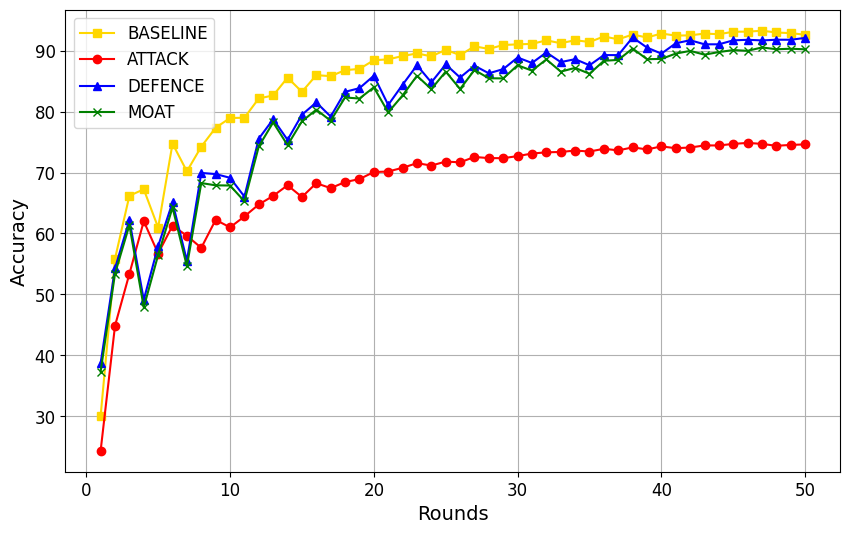

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['ROUND'], df['BASELINE'], marker='s', linestyle='-', label='BASELINE', color='gold')
plt.plot(df['ROUND'], df['ATTACK'], marker='o', linestyle='-', label='ATTACK', color='red')
plt.plot(df['ROUND'], df['DEFENCE'], marker='^', linestyle='-', label='DEFENCE', color='blue')
plt.plot(df['ROUND'], df['MOAT'], marker='x', linestyle='-', label='MOAT', color='green')

# Adding labels and title with increased font size
plt.xlabel('Rounds', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
# plt.title('90% poisoning', fontsize=16)

plt.legend(fontsize=12)

# Increase font size of ticks
plt.tick_params(axis='both', which='major', labelsize=12)

# plt.ylim(0, 100)
plt.grid(True)
plt.show()


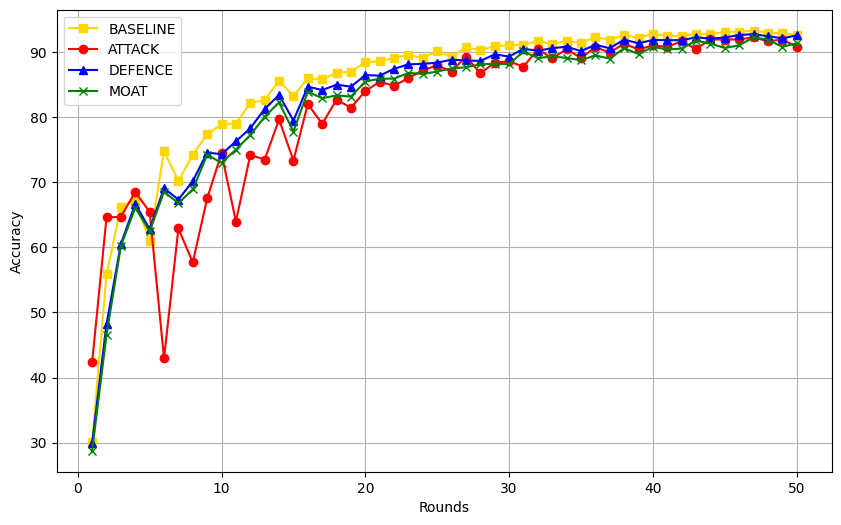

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['ROUND'], df['BASELINE'], marker='s', linestyle='-', label='BASELINE', color='gold')
plt.plot(df['ROUND'], df['ATTACK'], marker='o', linestyle='-', label='ATTACK', color='red')
plt.plot(df['ROUND'], df['DEFENCE'], marker='^', linestyle='-', label='DEFENCE', color='blue')
plt.plot(df['ROUND'], df['MOAT'], marker='x', linestyle='-', label='MOAT', color='green')

# Adding labels and title
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
# plt.title('90% poisoning')
plt.legend()

# plt.ylim(0, 100)
plt.grid(True)
plt.show()

In [ ]:
df.to_csv('Label_Flipping__90.csv')

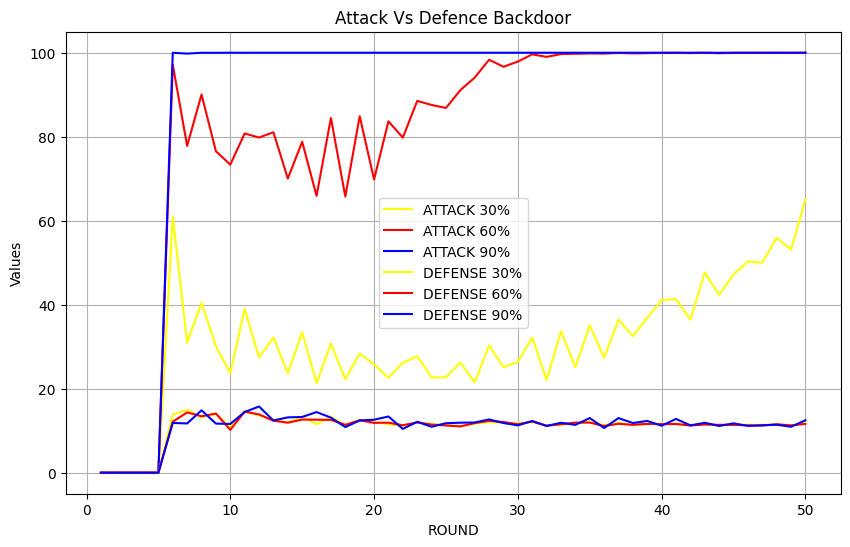

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['ROUND'], df['ATTACK_30'], label='ATTACK 30%', color='yellow')
plt.plot(df['ROUND'], df['ATTACK_60'], label='ATTACK 60%', color='red')
plt.plot(df['ROUND'], df['ATTACK_90'], label='ATTACK 90%', color='blue')

plt.plot(df['ROUND'], df['DEFENSE_30'], label='DEFENSE 30%', color='yellow')
plt.plot(df['ROUND'], df['DEFENSE_60'], label='DEFENSE 60%', color='red')
plt.plot(df['ROUND'], df['DEFENSE_90'], label='DEFENSE 90%', color='blue')

# Adding labels and title
plt.xlabel('ROUND')
plt.ylabel('Values')
plt.title('Attack Vs Defence Backdoor')
plt.legend()

# plt.ylim(0, 100)
plt.grid(True)
plt.show()

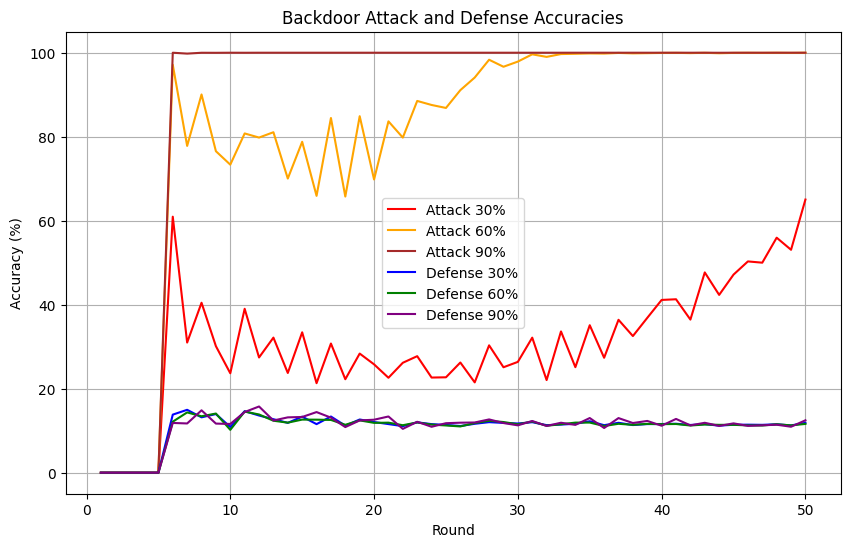

In [ ]:
# prompt: Plot the 3 attack and 3 defense columns of df, add legend

plt.figure(figsize=(10, 6))
plt.plot(df['ROUND'], df['ATTACK_30'], label='Attack 30%', color='red')
plt.plot(df['ROUND'], df['ATTACK_60'], label='Attack 60%', color='orange')
plt.plot(df['ROUND'], df['ATTACK_90'], label='Attack 90%', color='brown')
plt.plot(df['ROUND'], df['DEFENSE_30'], label='Defense 30%', color='blue')
plt.plot(df['ROUND'], df['DEFENSE_60'], label='Defense 60%', color='green')
plt.plot(df['ROUND'], df['DEFENSE_90'], label='Defense 90%', color='purple')

# Adding labels and title
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.title('Backdoor Attack and Defense Accuracies')
plt.legend()
plt.grid(True)
plt.show()

#RESNET_18


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.model_download("keras/resnetv1/keras/resnet_18_imagenet")

print("Path to model files:", path)


100%|██████████| 873/873 [00:00<00:00, 1.64MB/s]



100%|██████████| 836/836 [00:00<00:00, 1.93MB/s]



100%|██████████| 1.69k/1.69k [00:00<00:00, 2.93MB/s]



100%|██████████| 3.58k/3.58k [00:00<00:00, 7.55MB/s]


  0%|          | 0.00/189 [00:00<?, ?B/s]

100%|██████████| 189/189 [00:00<00:00, 80.2kB/s]



  0%|          | 0.00/44.8M [00:00<?, ?B/s]

  2%|▏         | 1.00M/42.8M [00:01<00:56, 780kB/s]
  2%|▏         | 1.00M/44.8M [00:01<00:59, 776kB/s]

  5%|▍         | 2.00M/42.8M [00:01<00:28, 1.51MB/s]
  4%|▍         | 2.00M/44.8M [00:01<00:29, 1.51MB/s]

  7%|▋         | 3.00M/42.8M [00:01<00:17, 2.40MB/s]
  7%|▋         | 3.00M/44.8M [00:01<00:18, 2.41MB/s]

 12%|█▏        | 5.00M/42.8M [00:01<00:09, 4.40MB/s]
 11%|█         | 5.00M/44.8M [00:01<00:09, 4.44MB/s]

 16%|█▋        | 7.00M/42.8M [00:01<00:05, 6.74MB/s]
 16%|█▌        | 7.00M/44.8M [00:01<00:05, 6.79MB/s]

 21%|██        | 9.00M/42.8M [00:02<00:04, 8.67MB/s]
 20%|██        | 9.00M/44.8M [00:02<00:04, 8.72MB/s]

 26%|██▌       | 11.0M/42.8M [00:02<00:03, 11.0MB/s]
 25%|██▍       | 11.0M/44.8M [00:02<00:03, 11.0MB/s]

 30%|███       | 13.0M/42.8M [00:02<00:02, 12.1MB/s]
 29%|██▉       | 13.0M/44.8M [00:02<00:02, 12.1MB/s]

 35%|███▌      | 15.0M/42.8M [00:02<00:02, 12.8MB/s]
 33%|███▎      | 15.0M/44.8M [00:02<00:02, 13.

Path to model files: /root/.cache/kagglehub/models/keras/resnetv1/keras/resnet_18_imagenet/3


In [ ]:
!pip install -U -q keras-hub

In [ ]:
!pip install -U -q keras


In [ ]:
    import keras_hub
    import numpy as np
    # Pretrained ResNet backbone.
    model = keras_hub.models.ResNetBackbone.from_preset("resnet_18_imagenet")
    input_data = np.random.uniform(0, 1, size=(2, 28, 28, 3))
    model(input_data)

    # # Randomly initialized ResNetV2 backbone with a custom config.
    # model = keras_hub.models.ResNetBackbone(
    #     input_conv_filters=[64],
    #     input_conv_kernel_sizes=[7],
    #     stackwise_num_filters=[64, 64, 64],
    #     stackwise_num_blocks=[2, 2, 2],
    #     stackwise_num_strides=[1, 2, 2],
    #     block_type="basic_block",
    #     use_pre_activation=True,
    # )
    # model(input_data)
    # # Use resnet for image classification task
    # model = keras_hub.models.ImageClassifier.from_preset("resnet_18_imagenet")

    # # User timm presets directly from hugingface
    # model = keras_hub.models.ImageClassifier.from_preset('hf://timm/resnet18.a1_in1k')


Download already complete (836 bytes).
Download already complete (44918352 bytes).


<tf.Tensor: shape=(2, 1, 1, 512), dtype=float32, numpy=
array([[[[0.       , 0.       , 0.4200412, ..., 0.       , 0.       ,
          0.       ]]],


       [[[0.       , 0.       , 1.7032316, ..., 0.       , 0.       ,
          0.       ]]]], dtype=float32)>

In [ ]:
X_train.shape

(60000, 28, 28, 3)

In [ ]:
import keras_hub
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Pretrained ResNet backbone.
model = keras_hub.models.ResNetBackbone.from_preset("resnet_18_imagenet")

# Add an input layer with the desired shape
inputs = keras.Input(shape=(224, 224, 3))

# # Reshape the input to match ResNet's expected input shape
# resized_input = layers.Resizing(224, 224)(inputs)  # Resize to (224, 224)

# Pass the resized input to the ResNet backbone
x = model(inputs)

# Add classification layers on top of the ResNet backbone
x = layers.GlobalAveragePooling2D()(x)  # Reduce spatial dimensions
x = layers.Dense(10, activation='softmax')(x)  # Output layer for 10 classes

# Create the final model
model = keras.Model(inputs=inputs, outputs=x)

# Compile the model
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(train_images_resized, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


In [ ]:
!pip install git+https://github.com/slundberg/shap.git

  Cloning https://github.com/slundberg/shap.git to /tmp/pip-req-build-tts9_a0g
  Running command git clone --filter=blob:none --quiet https://github.com/slundberg/shap.git /tmp/pip-req-build-tts9_a0g
  Resolved https://github.com/slundberg/shap.git to commit da0ce7da0073a13338d8529b86d4471d18310687
  Installing build dependencies ... done
  Getting requirements to build wheel ... canceled
ERROR: Operation cancelled by user


In [ ]:
import tensorflow as tf

# Convert MNIST images to TensorFlow tensors and resize
X_train = tf.image.resize(X_train[:5][..., tf.newaxis], [224, 224]).numpy()
X_test = tf.image.resize(X_test[:5][..., tf.newaxis], [224, 224]).numpy()

# Check new shape
print(X_train.shape)  # (60000, 224, 224, 1)
print(X_test.shape)   # (10000, 224, 224, 1)


(5, 224, 224, 1)
(5, 224, 224, 1)


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Function to resize images
def resize_images(images, size=(224, 224)):
    resized_images = np.array([cv2.resize(img, size, interpolation=cv2.INTER_LINEAR) for img in images])
    return resized_images

# Resize training and testing images
X_train = resize_images(train_images)
X_test = resize_images(test_images)

# Check new shape
print(X_train.shape)  # (60000, 224, 224)
print(X_test.shape)   # (10000, 224, 224)


(60000, 224, 224)
(10000, 224, 224)


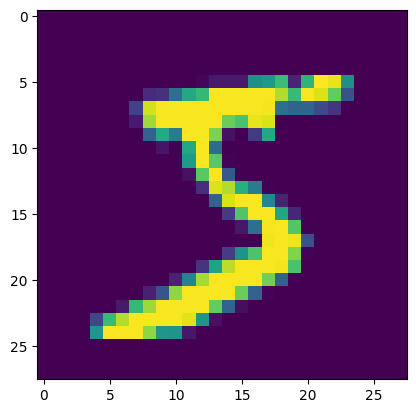

In [ ]:
# prompt: Plot the first image of  X_train

import matplotlib.pyplot as plt

plt.imshow(X_train[0])
plt.show()


In [ ]:


import keras_hub
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Pretrained ResNet backbone.
model = keras_hub.models.ResNetBackbone.from_preset("resnet_18_imagenet")

# Add an input layer with the desired shape
inputs = keras.Input(shape=(28, 28, 3))

# Reshape the input to match ResNet's expected input shape
# resized_input = layers.Resizing(224, 224)(inputs)  # Resize to (224, 224)

# Pass the resized input to the ResNet backbone
x = model(inputs) # Pass resized_input instead of inputs

# Add classification layers on top of the ResNet backbone
x = layers.GlobalAveragePooling2D()(x)  # Reduce spatial dimensions
x = layers.Dense(10, activation='softmax')(x)  # Output layer for 10 classes

# Create the final model
model = keras.Model(inputs=inputs, outputs=x)

# Compile the model
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Take a random sample of 100 training images
background = X_train[np.random.choice(X_train.shape[0] , 100, replace = False)]

In [ ]:
e = shap.DeepExplainer(model , background)

In [ ]:
def plot_shap(image_list , index_img_list):

    shap_values = e.shap_values(image_list)
    # shap_values_array = np.array(shap_values)
    shap_values = np.transpose(shap_values, (4, 0, 1, 2, 3))
    # percentages = labels * 100
    labels = np.round(percentages, 2)
    shap.image_plot(shap_numpy, -index_img_list, labels = index_img_list)
    plt.show()

In [ ]:
X_train[:5].shape

(5, 28, 28, 3)

In [ ]:
shap_values = e.shap_values(X_train[:5])

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_290
Received: inputs=['Tensor(shape=(200, 28, 28, 3))']
  raise ValueError(msg)


StagingError: in user code:

    File "/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py", line 269, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_ResizeBilinear


In [ ]:
plot_shap(np.array(X_train[:5]) , np.array(y_train[:5]))

In [ ]:
x_train_list = []
for i in range(5):
  x_train_list.append(X_train[i])

In [ ]:
np.array(x_train_list).shape

(5, 28, 28, 3)

In [ ]:
import shap
import numpy as np

def plot_shap(image_list , index_img_list):
    """
    Plots SHAP values for the given image list.

    Args:
        image_list: List of images to explain.
        index_img_list: List of indices or labels for the images.
    """

    # Reshape the image_list to have a defined batch dimension if it's missing
    if image_list.shape[0] is None or image_list.shape[0] == 0:
        image_list = image_list.reshape(1, *image_list.shape[1:])
    # OR
    # image_list = image_list[np.newaxis, ...]  # Add a batch dimension

    shap_values = e.shap_values(image_list)
    shap_numpy = [np.swapaxes(s, 2, 3) for s in shap_values] # shap_values has shape (num_classes, num_images, height, width, channels)
    shap_numpy = [np.swapaxes(s, 1, 2) for s in shap_numpy] # shap_values has shape (num_classes, height, width, num_images, channels)
    labels = model.predict(image_list)
    percentages = labels * 100
    labels = np.round(percentages, 2)
    # shap.image_plot(shap_numpy, -image_list, labels=labels) # changed here
    shap.image_plot(shap_numpy, image_list, labels=labels)
    plt.show()

In [ ]:
def gen_shap(model_weights, x_test , y_test, background_size=1000, test_size=100):
    """
    Generate SHAP values for the given model and test data

    model_weights: Initialize the model_weights
    x_test: Test data
    y_test: Test labels
    background_size: Number of background samples to use for SHAP values
    test_size: Number of test samples to use for SHAP values
    """
    client_model = load_model()
    client_model.set_weights(model_weights)

    background = x_test[:background_size]
    print("Shap Object training started")
    e = shap.DeepExplainer(client_model, background)
    print("Shap Object training completed")
    df_list = []
    # for class_index in range(10):
    for class_index in [0,6]:
        X_test_final = np.array(specific_label_test(class_index , test_size , x_test , y_test))
        print("Shap values generation started for class:" , class_index)
        print("Length of X_test_final: ", X_test_final.shape)
        shap_values = e.shap_values(X_test_final)

        print("Shap values generation completed for class:" , class_index)
        # shap_values_array = np.array(shap_values)
        shap_values = np.transpose(shap_values, (4, 0, 1, 2, 3))
        print(shap_values.shape)
        shap_image = shap_values[class_index]
        print(shap_image.shape)
        reshaped_data = shap_image.reshape(shap_image.shape[1], -1)
        df_list.append(pd.DataFrame(reshaped_data))
        # df.to_csv(f'shap_values_{class_idx[0]}_Client.csv', index=False)

    return df_list

In [ ]:
tf.__version__

'2.18.0'

In [ ]:
pip freeze

absl-py==1.4.0
accelerate==1.3.0
aiohappyeyeballs==2.4.6
aiohttp==3.11.13
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.6.0
arviz==0.20.0
astropy==7.0.1
astropy-iers-data==0.2025.3.3.0.34.45
astunparse==1.6.3
atpublic==4.1.0
attrs==25.1.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.38.0
bigquery-magics==0.6.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blosc2==3.2.0
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.20.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.